In [80]:
#######################################################
#-- ***Parent Directory and code for ALL inversions***
#######################################################

#dir = "/discover/nobackup/projects/csu/aschuh/data/inversion_workshop_data/"
#dir = "/discover/nobackup/projects/csu/aschuh/SSIM-GHG/base"
#dir = "/Users/aschuh/SSIM-GHG/"
dir = "../"

output_dir="../output/"

###############################################
#-- Load Code
##############################################
source(file.path(dir,"data/R_code/util_code_032024.R"))
source(file.path(dir,"data/R_code/inversion_032024.R"))
source(file.path(dir,"data/R_code/write_inversion_2_netcdf_032024.R"))

###############################################
#-- Required Libraries
###############################################
require(ncdf4)
require(plyr)
require(dplyr)
require(parallel)
require(ggplot2)
require(abind)
require(Matrix)
require(lattice)

In [70]:
###############################################
#--  Load sensitivity matrices 
###############################################

load(file.path(dir,"data/sensitivity_matrices/","trunc_full_jacob_030624_with_dimnames_sib4_4x5_mask.rda"))
load(file.path(dir,"data/sensitivity_matrices/","jacob_bgd_021624.rda"))


###################################################################
#-- END END END ***Parent Directory and code for ALL inversions***
###################################################################


In [71]:

##################################################################
#- Inversion #1   *************************
##################################################################

#################################
#- Target truth in state space
#################################

##################################################################
#-- This array holds ratios of OCO2v10MIP fluxes and SiB4 fluxes
#-- as examples of "scalings" to be recovered. It also holds corresponding
#-- differences if the inversion attempts to directly solve for flux
#-- truth_array(24 months, 23 transcom, 98 inversions, (ratio, difference) )
##################################################################

#load("/projects/sandbox/inversion_workshop_scripts/truth_array.rda")
load(file.path(dir,"data/truth_array.rda"))

xx = truth_array[,-1,1,1]

state_vector_true= tm(as.vector(truth_array[,-1,1,1]),-1,1)

#state_vector_true = c(rep(0.5,24*11),rep(-0.5,24*11))

#state_vector_mat = matrix(state_vector_true,nrow=24,byrow=FALSE)
#dim(state_vector_mat)
#state_vector_mat[,15]

In [72]:
#########################################################
# Generate a prior flux covariance matrix P_0
# Long term, a catalog of predefined choices is best here I think
#########################################################
land_prior_sd = 0.5
ocean_prior_sd = 1

#-- induce temporal correlations
sigma = bdiag(rep(list(ar_covariance(24, 0.5)), 22))

#-- scale by variance for land/ocean
var_scaling_diagonal = diag(c(rep(land_prior_sd,24*11),rep(ocean_prior_sd,24*11)))
sigma = var_scaling_diagonal %*% sigma %*% t(var_scaling_diagonal)

In [73]:
##########################################################
#-- sd for Gaussian i.i.d. errors, jacob is sens matrix
##########################################################
R_diagonal_in = rep(3,(dim(jacob)[1]))

In [74]:
##########################################
#-- Generate obs, 'y',  set.seed() ????
##########################################

y_in = generate_observations(H=jacob,H_bgd=jacob_bgd,
                             state_vector=state_vector_true,err_obs=R_diagonal_in)


In [82]:
####################################################################################
#-- WHICH obs do you want to use in the inversion? 
#-- examples of selecting on stations, type of data, lat/lon box,etc
####################################################################################

load(file.path(dir,"data/obs_catalog_030624.rda")) # obs_catalog object

#subset_indicator_obs=rep(FALSE,dim(jacob)[1])
subset_indicator_obs=rep(TRUE,dim(jacob)[1])

#subset_indicator_obs=c(rep(TRUE,156383),rep(FALSE,1000000))

############################
#-- SAMPLE BY TYPE EXAMPLE
############################
#subset_indicator_obs[obs_catalog$TYPE == "TCCON"] = TRUE

############################
#-- SAMPLE BY NOAA STATION EXAMPLE
############################
#subset_indicator_obs[grep("spo",obs_catalog$ID)] = TRUE
#subset_indicator_obs[grep("lef",obs_catalog$ID)] = TRUE

############################
#-- SAMPLE BY TIME EXAMPLE
############################
#subset_indicator_obs[obs_catalog$TIME > 8738000] = TRUE

############################
#-- SAMPLE BY LON & LAT EXAMPLE
############################
#subset_indicator_obs[obs_catalog$LON < -10 & obs_catalog$LAT > 10] = TRUE

#subset_indicator_obs=c(rep(TRUE,1156382),rep(FALSE,1))
#subset_indicator_obs[seq(1,1156383,by=100)] = TRUE


$$
\newcommand{\transpose}[1]{{#1^{\scriptscriptstyle T}}} 
J(x) = \transpose{(x_0 - x)} {\Sigma_x
}^{-1}(x_0 - x) + \transpose{(y - Hx)} {\Sigma_y}^{-1}(y - Hx)\\
$$

$$
\newcommand{\transpose}[1]{{#1^{\scriptscriptstyle T}}} 
\hat{x} = (\transpose{H}{\Sigma_y}^{-1}H + {\Sigma_x}^{-1})^{-1}(\transpose{H}{\Sigma_y}^{-1}(y-Hx)+{\Sigma_x}^{-1}x_0)
$$

$$
\newcommand{\transpose}[1]{{#1^{\scriptscriptstyle T}}} 
\Sigma_{\hat{x}} = {({\Sigma_x}^{-1} + \transpose{H}{\Sigma_y}^{-1}H )}^{-1}
$$







In [83]:
############################
#-- Run the actual inversion
############################

ret2 = invert_clean(H=jacob,R_diagonal=R_diagonal_in,P_0=sigma,y=y_in,H_bgd=jacob_bgd,
                    subset_indicator_obs=subset_indicator_obs)



[1] "...cross product"
[1] ".. .deriving posterior covariance matrix of state, P"
[1] "DFS: 412.391566655134"
[1] "DFB: 115.608433344866"
[1] "...deriving posterior mean state, X_hat"
[1] "Done....writing inversion object output"


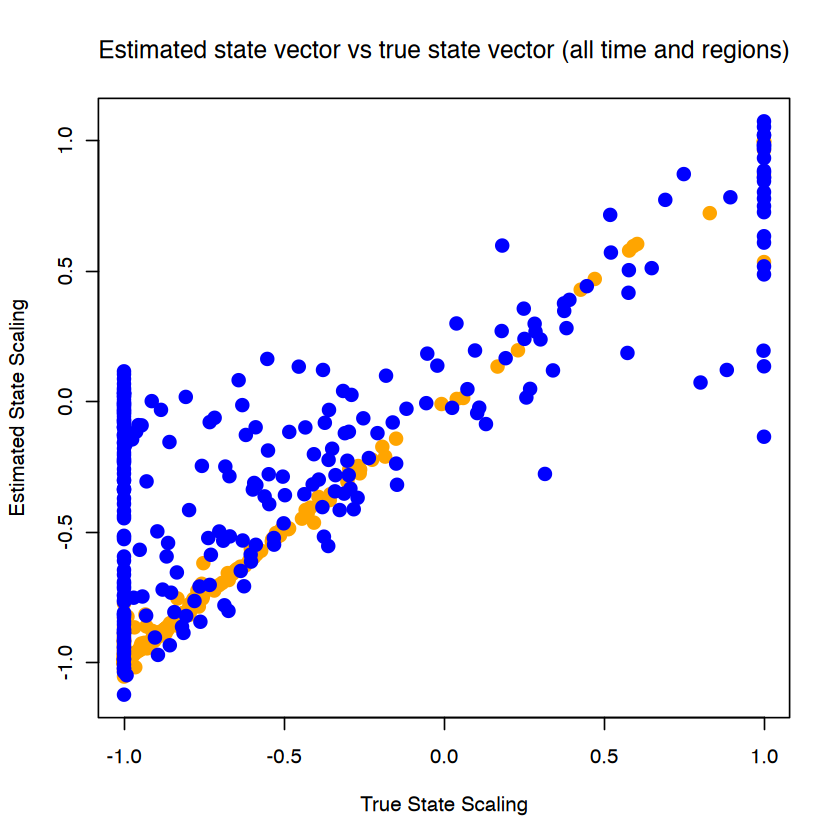

In [84]:
#hist(ret2$posterior$x_hat[,1])
plot(state_vector_true,ret2$posterior$x_hat,pch=16,cex=1.5,col=c(rep("orange",264),rep("blue",264)),
     xlab="True State Scaling",ylab="Estimated State Scaling",main="Estimated state vector vs true state vector (all time and regions)")

In [85]:
#############################################
#-- Output data from inversion to netcdf
#############################################

##3#################################
#--  run time pretty proportional to sample_number below, beware
####################################

write_inversion_2_netcdfs(inv_object=ret2$posterior,
                          prior_mean_ncdf=file.path(dir,"data/prior_SiB4.nc"),
                          output_dir=paste(output_dir,"test_output_posterior",sep=""),
                         sample_number=80)

write_inversion_2_netcdfs(inv_object=ret2$prior,
                          prior_mean_ncdf=file.path(dir,"data/prior_SiB4.nc"),
                          output_dir=paste(output_dir,"test_output_prior",sep=""),
                         sample_number=80)


Warning message in write_inversion_2_netcdfs(inv_object = ret2$posterior, prior_mean_ncdf = file.path(dir, :
“overwriting inversion results in ../output/test_output_posterior”


[1] "pulling multivariate normal sample...."
[1] "writing state vector output..to  ../output/test_output_posterior/state_vector.nc4"
[1] "creating gridded fluxes...."
[1] "writing gridded fluxes...to  ../output/test_output_posterior/gridded_fluxes.nc4"
[1] "creating cosamples output...."
[1] "writing cosamples output...to  ../output/test_output_posterior/cosamples.nc4"


Warning message in write_inversion_2_netcdfs(inv_object = ret2$prior, prior_mean_ncdf = file.path(dir, :
“overwriting inversion results in ../output/test_output_prior”


[1] "pulling multivariate normal sample...."
[1] "writing state vector output..to  ../output/test_output_prior/state_vector.nc4"
[1] "creating gridded fluxes...."
[1] "writing gridded fluxes...to  ../output/test_output_prior/gridded_fluxes.nc4"
[1] "creating cosamples output...."
[1] "writing cosamples output...to  ../output/test_output_prior/cosamples.nc4"


In [95]:
ret = organize_data_for_plotting(prior_flux_netcdf=paste(output_dir,"test_output_prior/gridded_fluxes.nc4",sep=""),
                                 posterior_flux_netcdf=paste(output_dir,"test_output_posterior/gridded_fluxes.nc4",sep=""))   

[1] "you have 12 cores to work with"


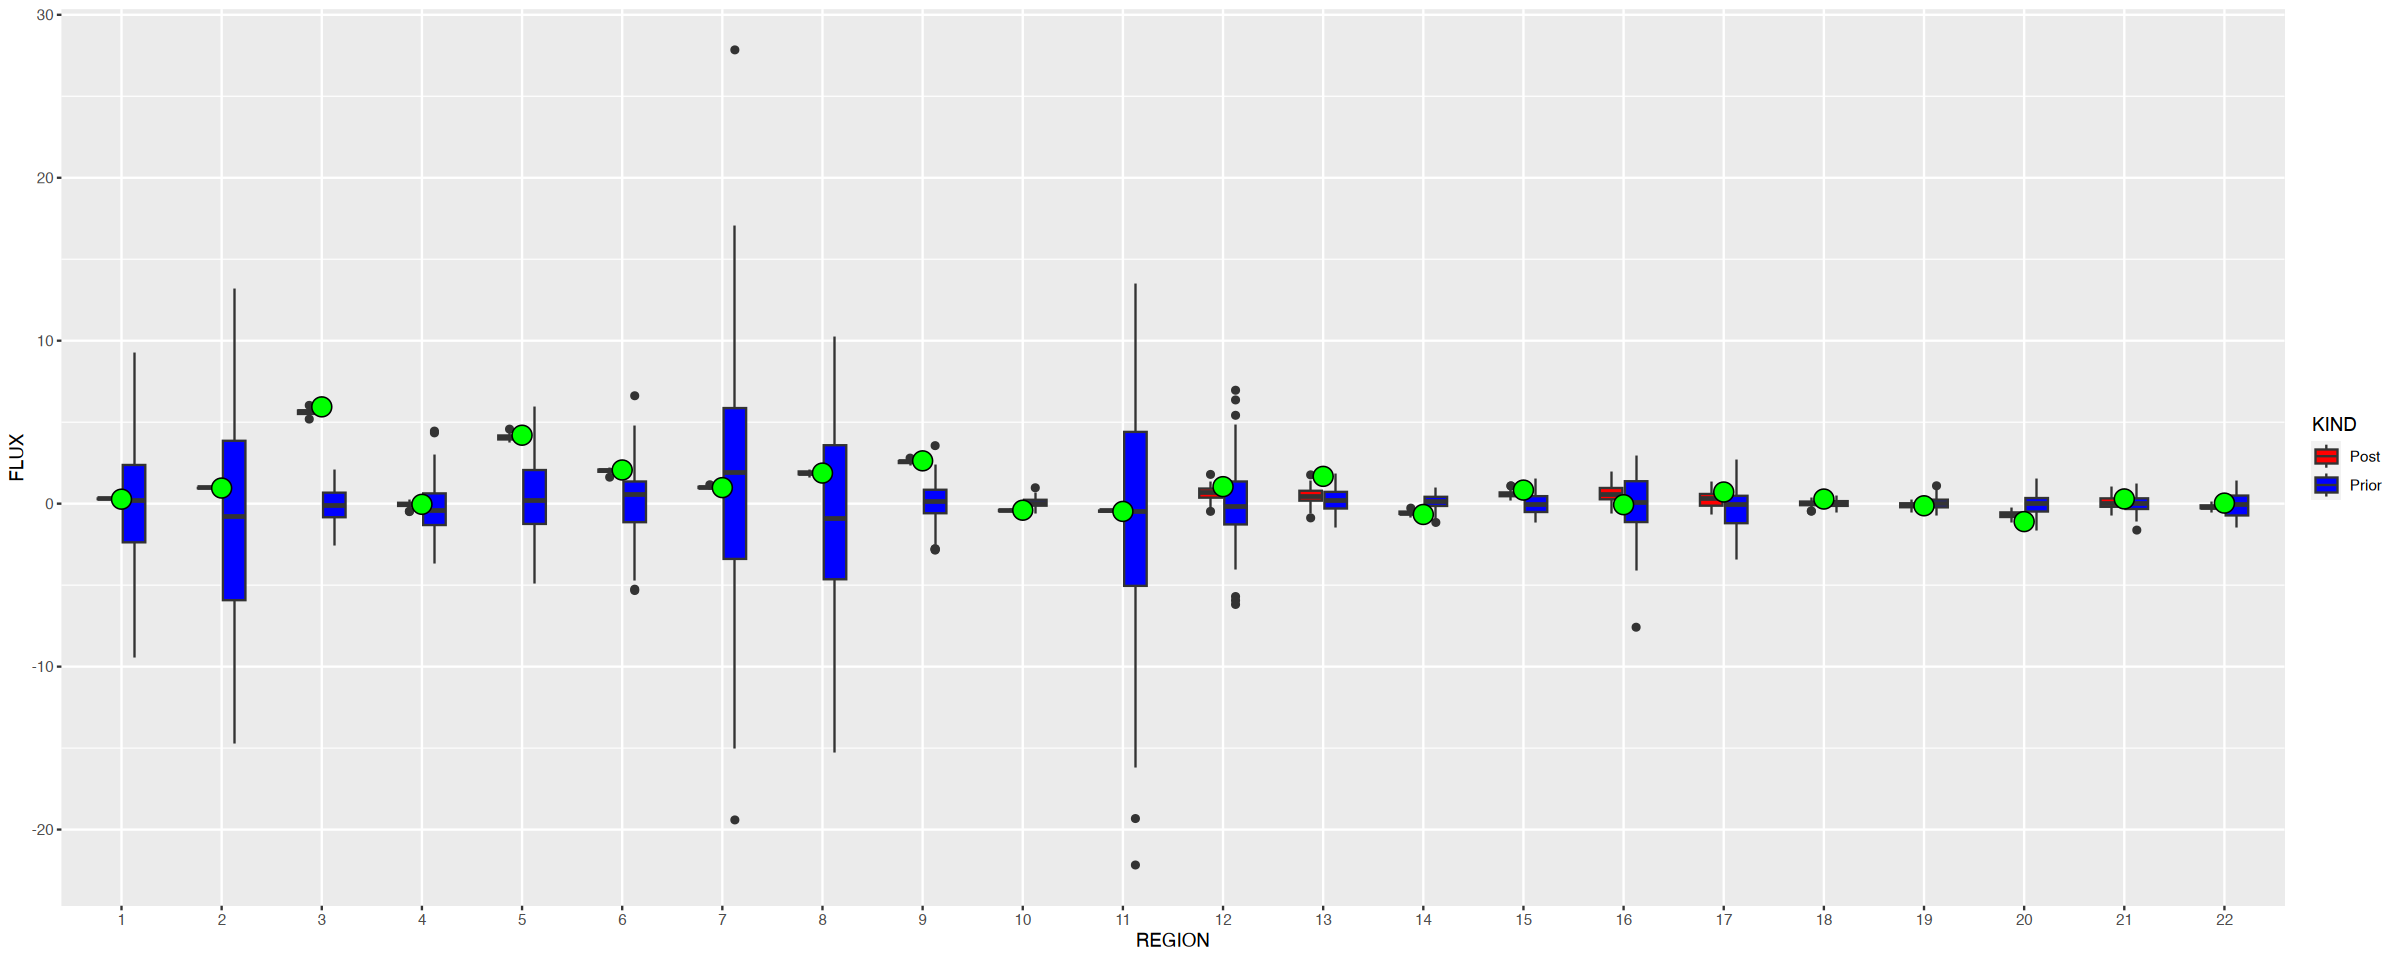

In [96]:
plot_timeseries_flux_bytranscom()

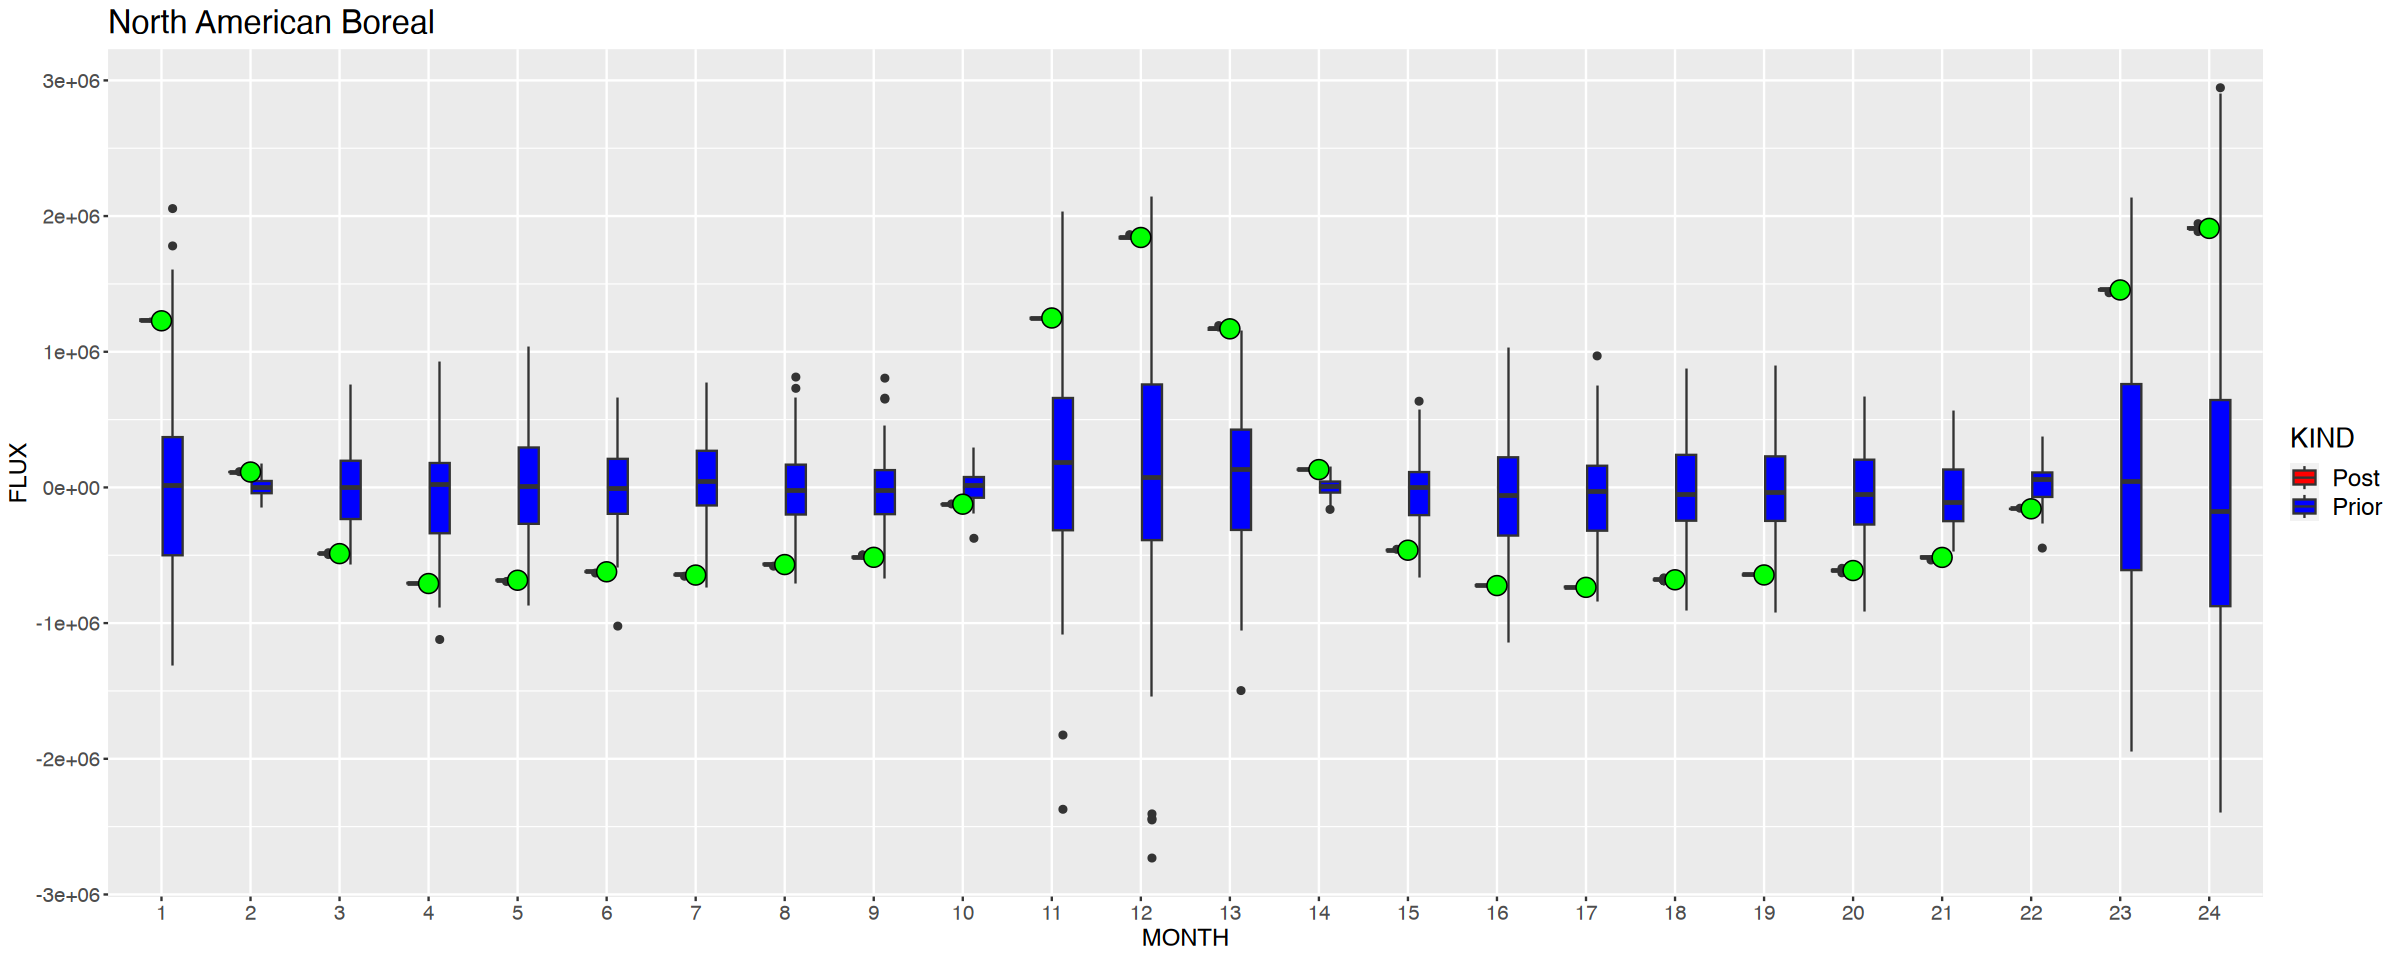

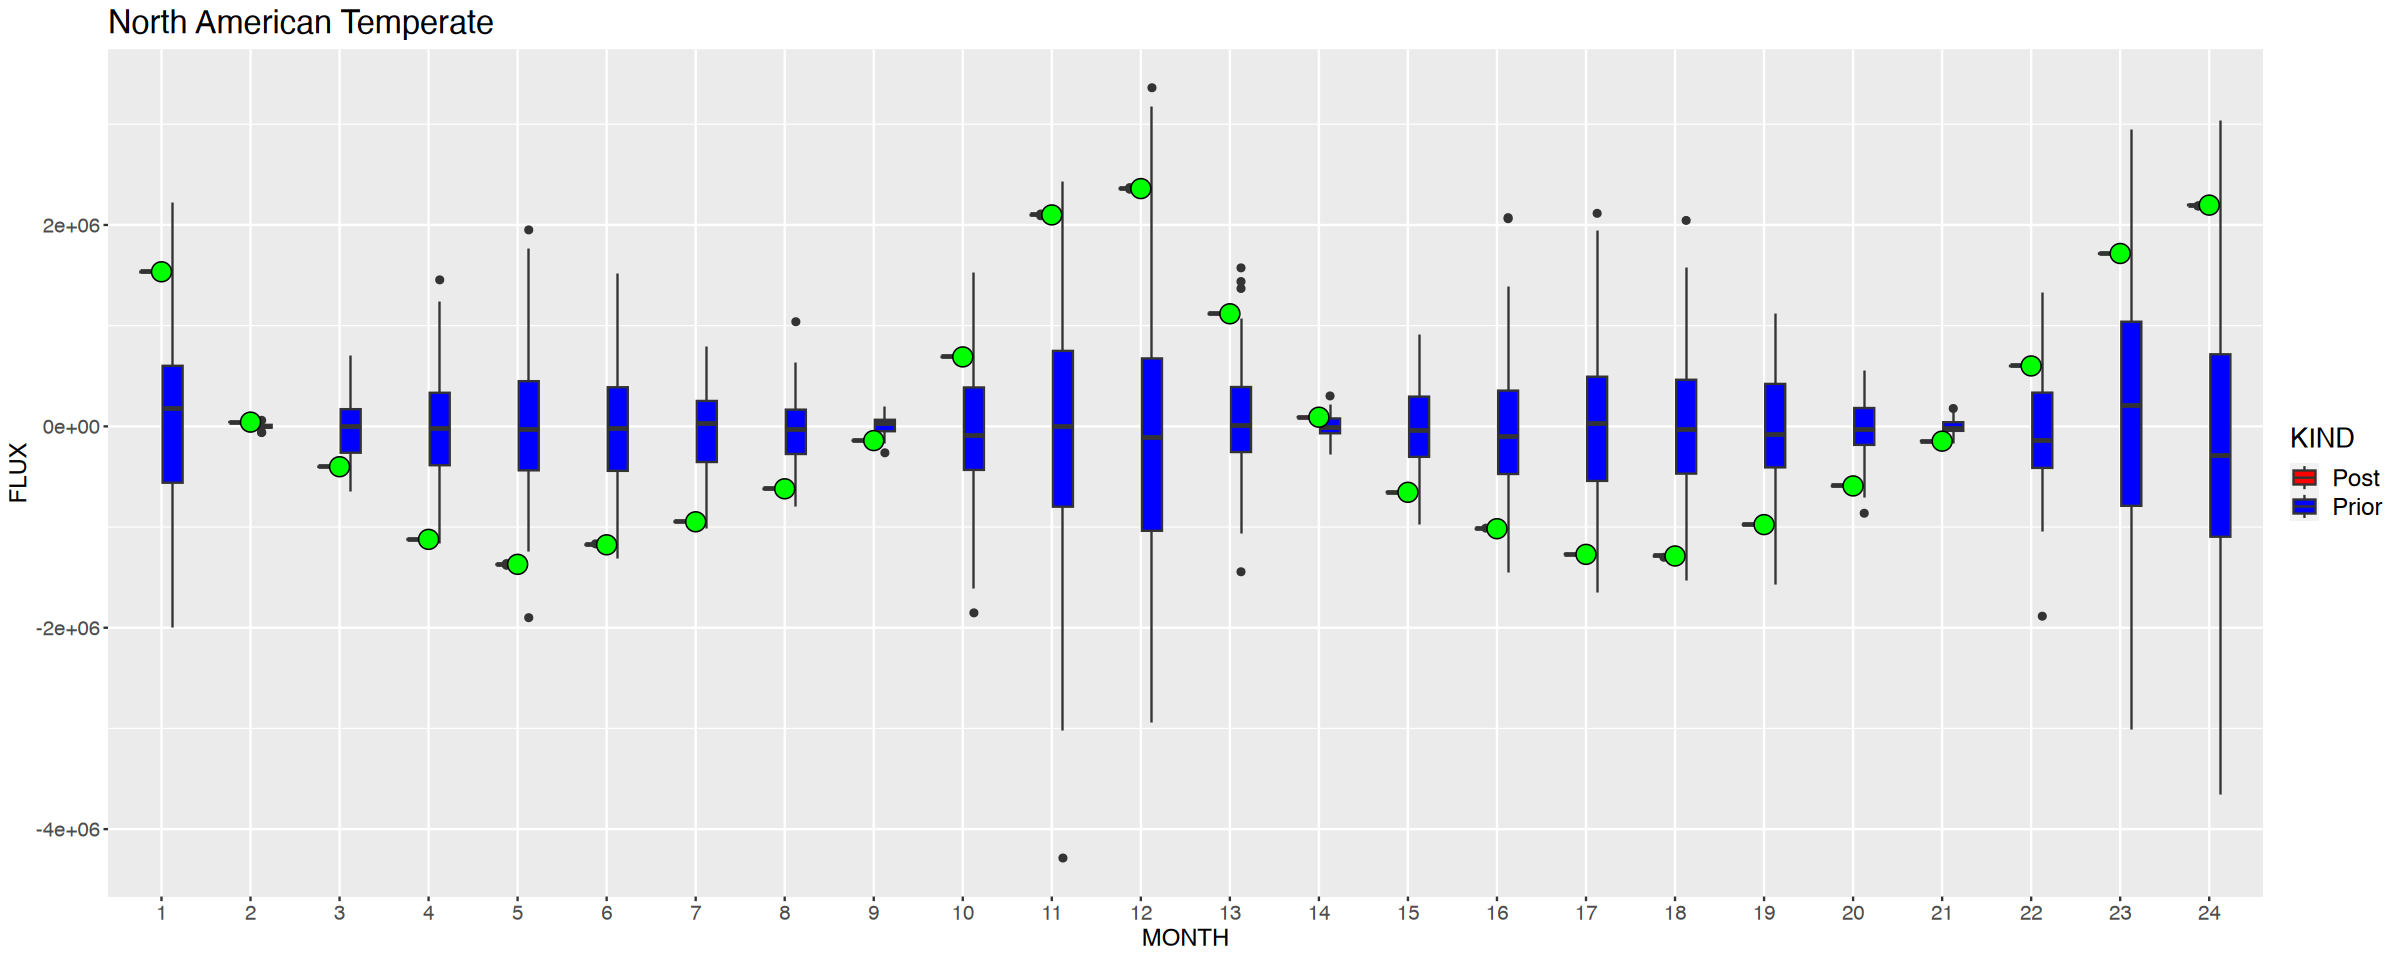

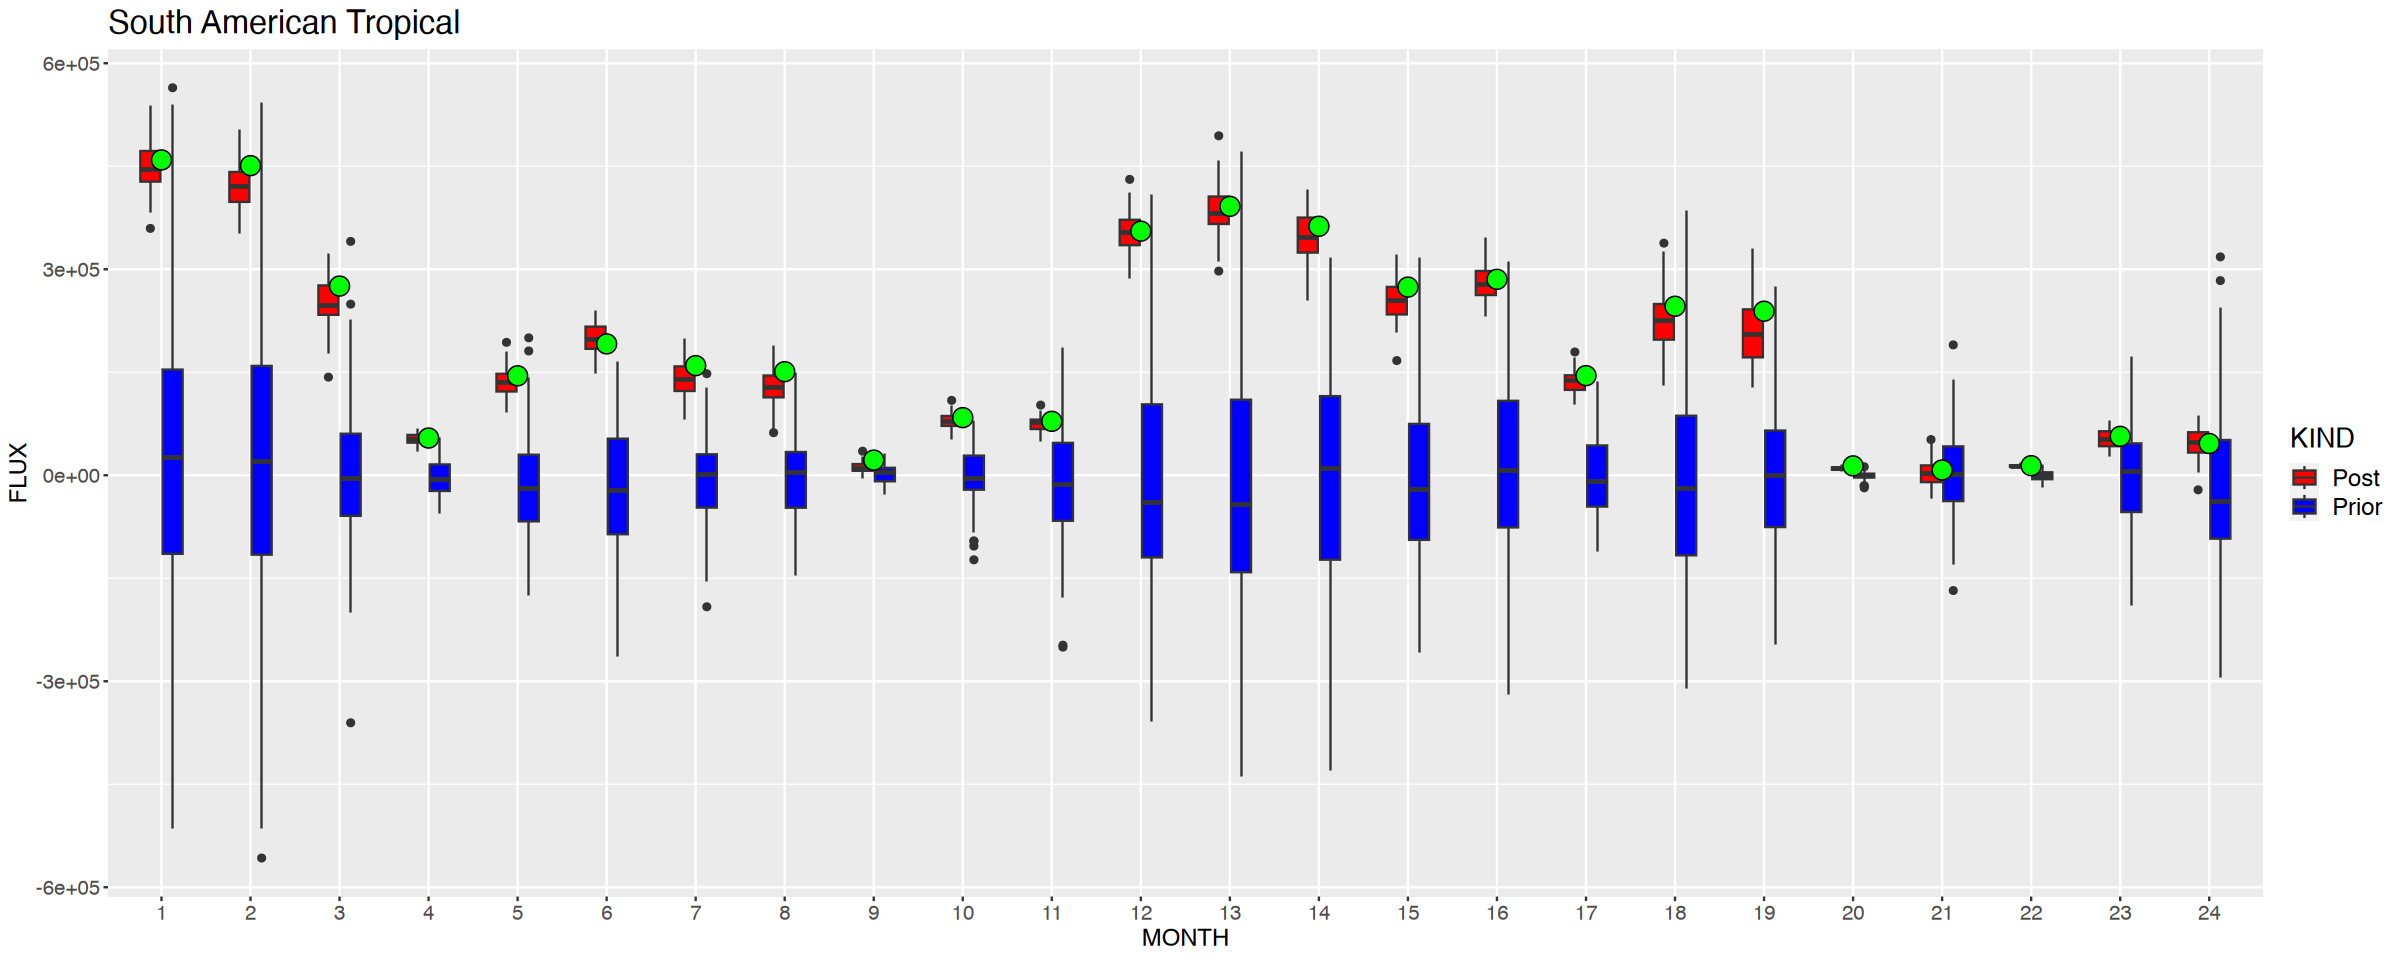

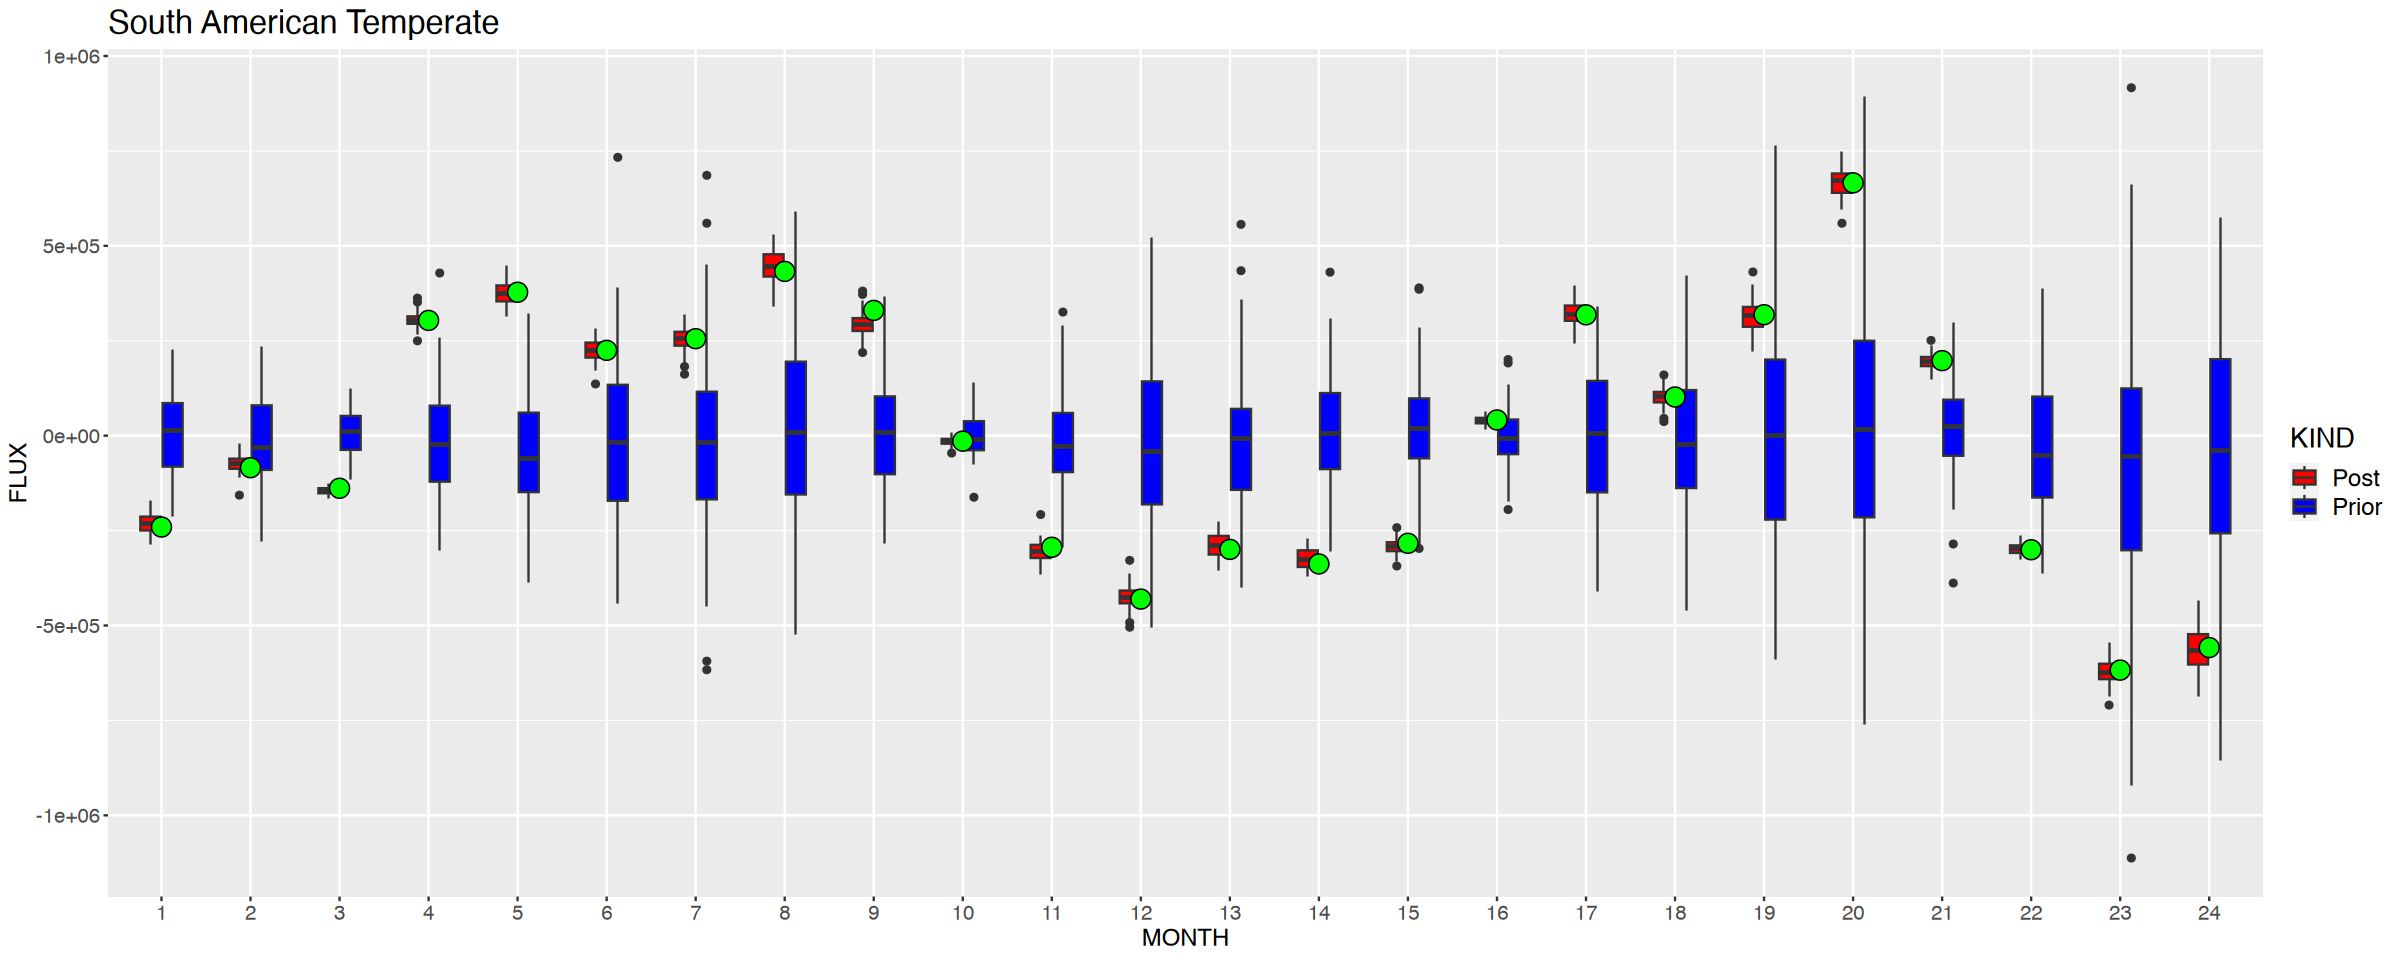

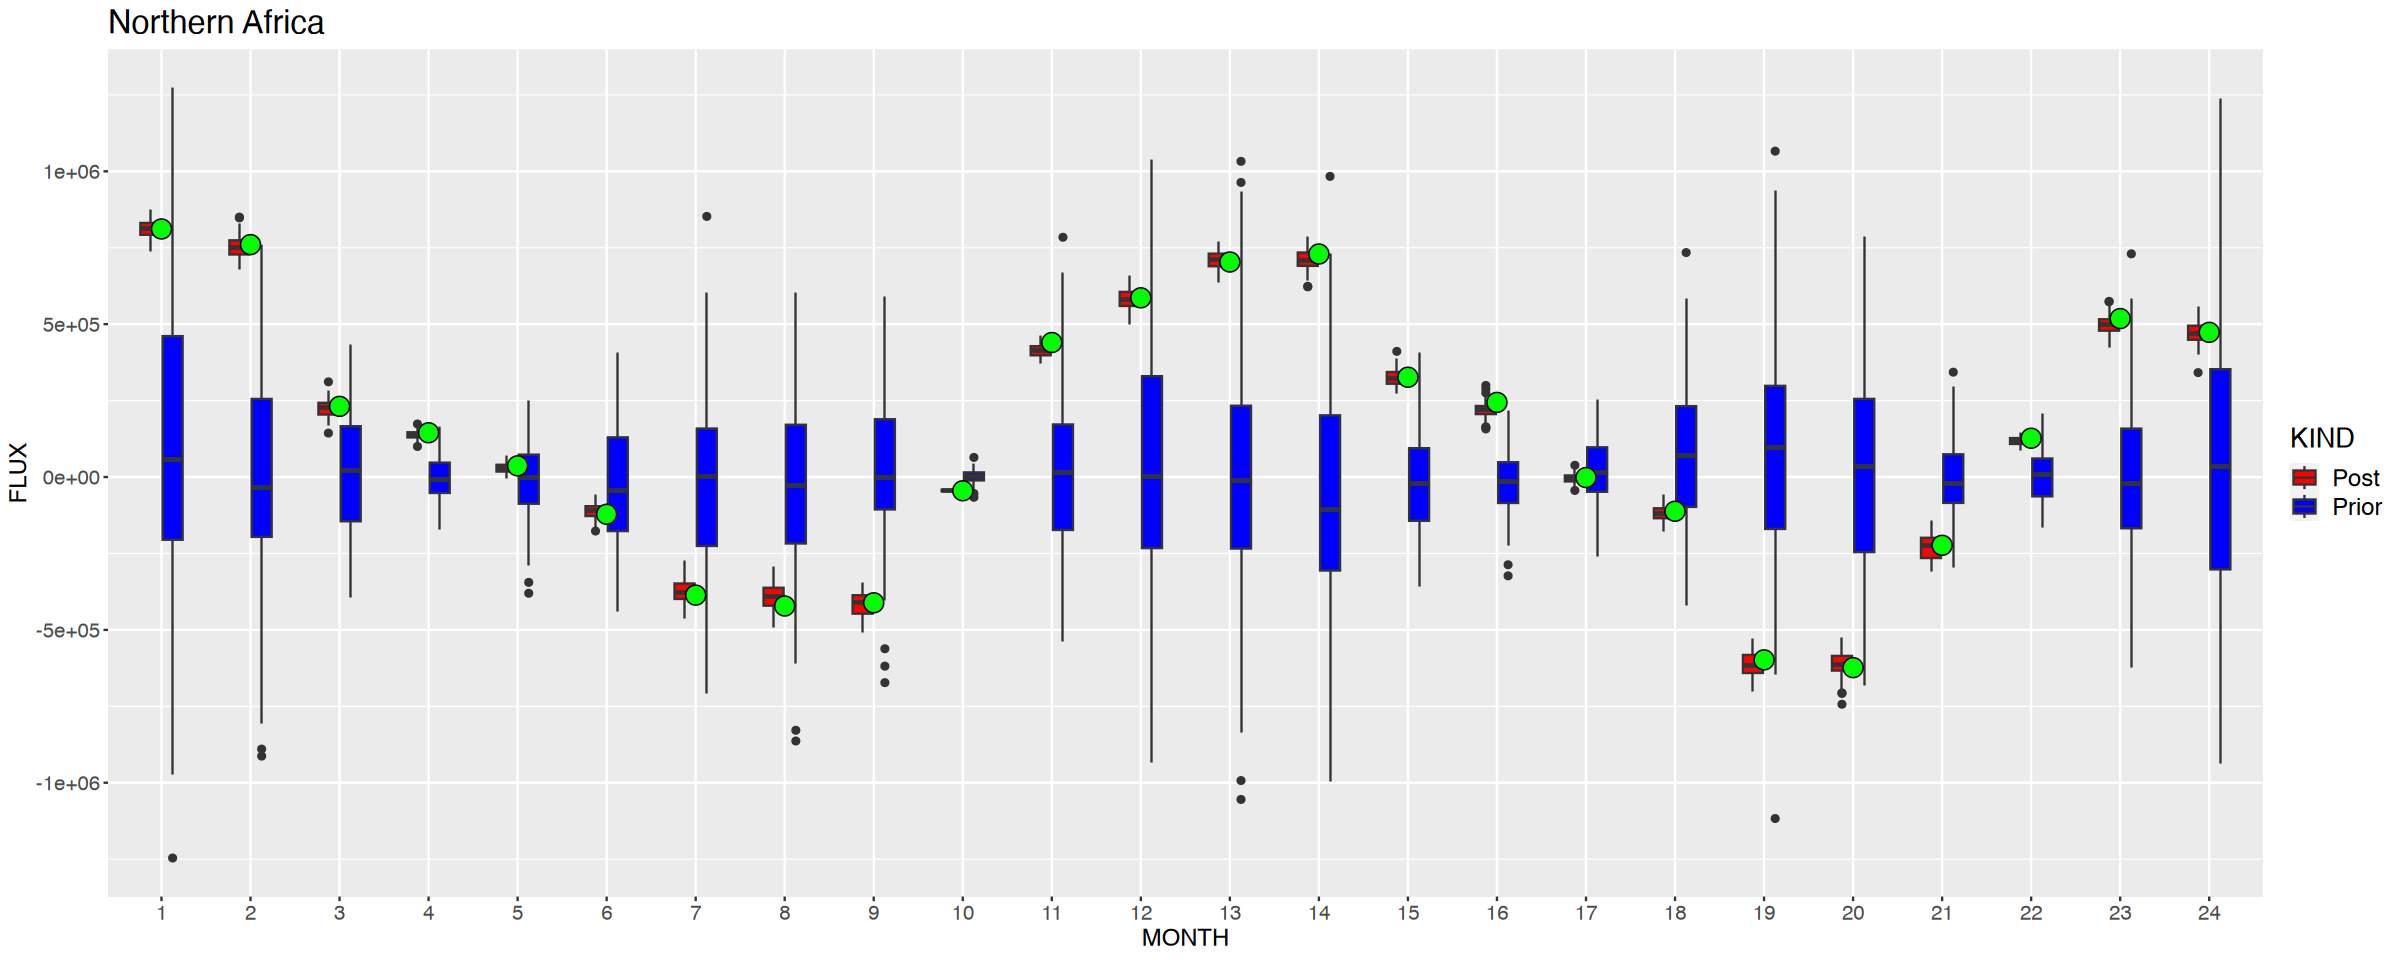

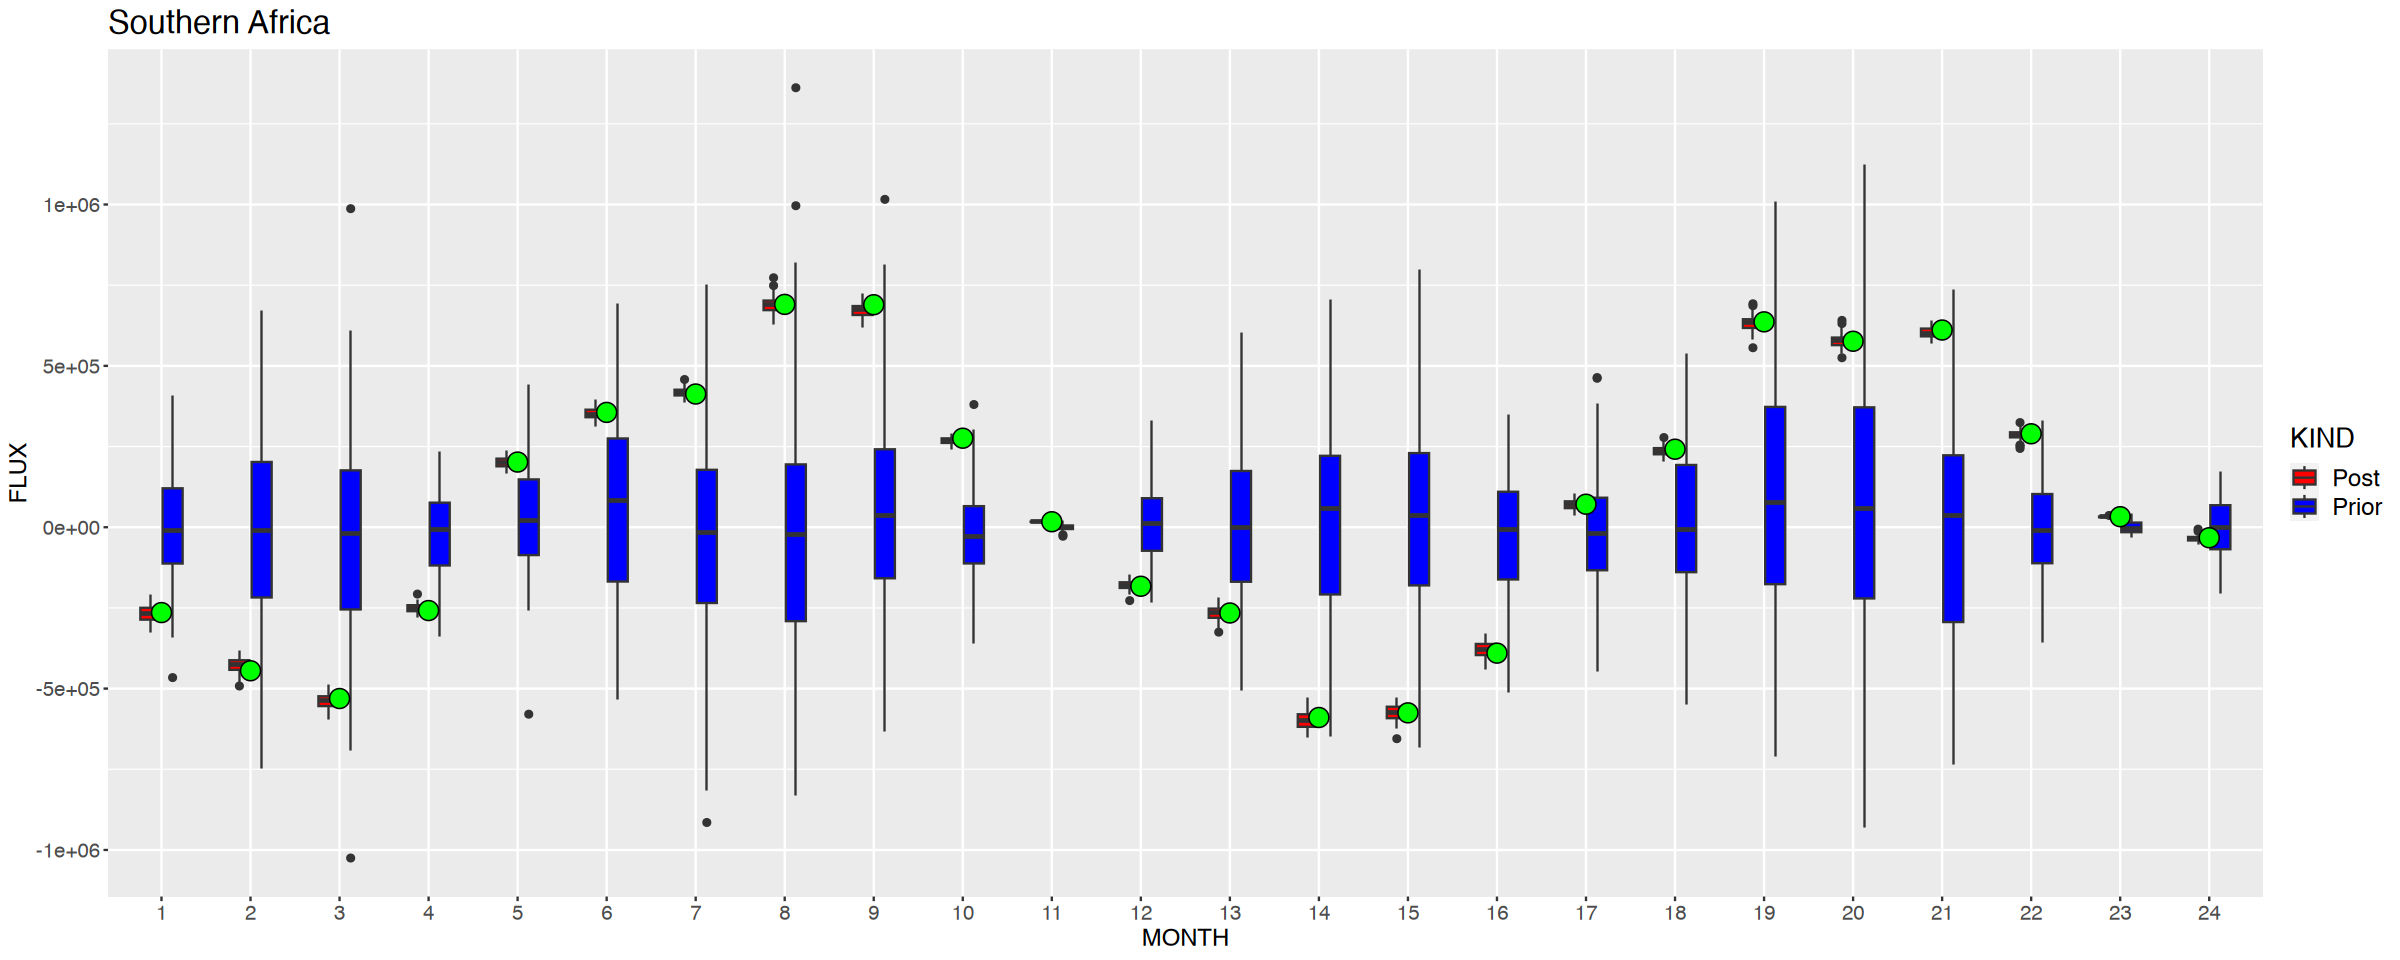

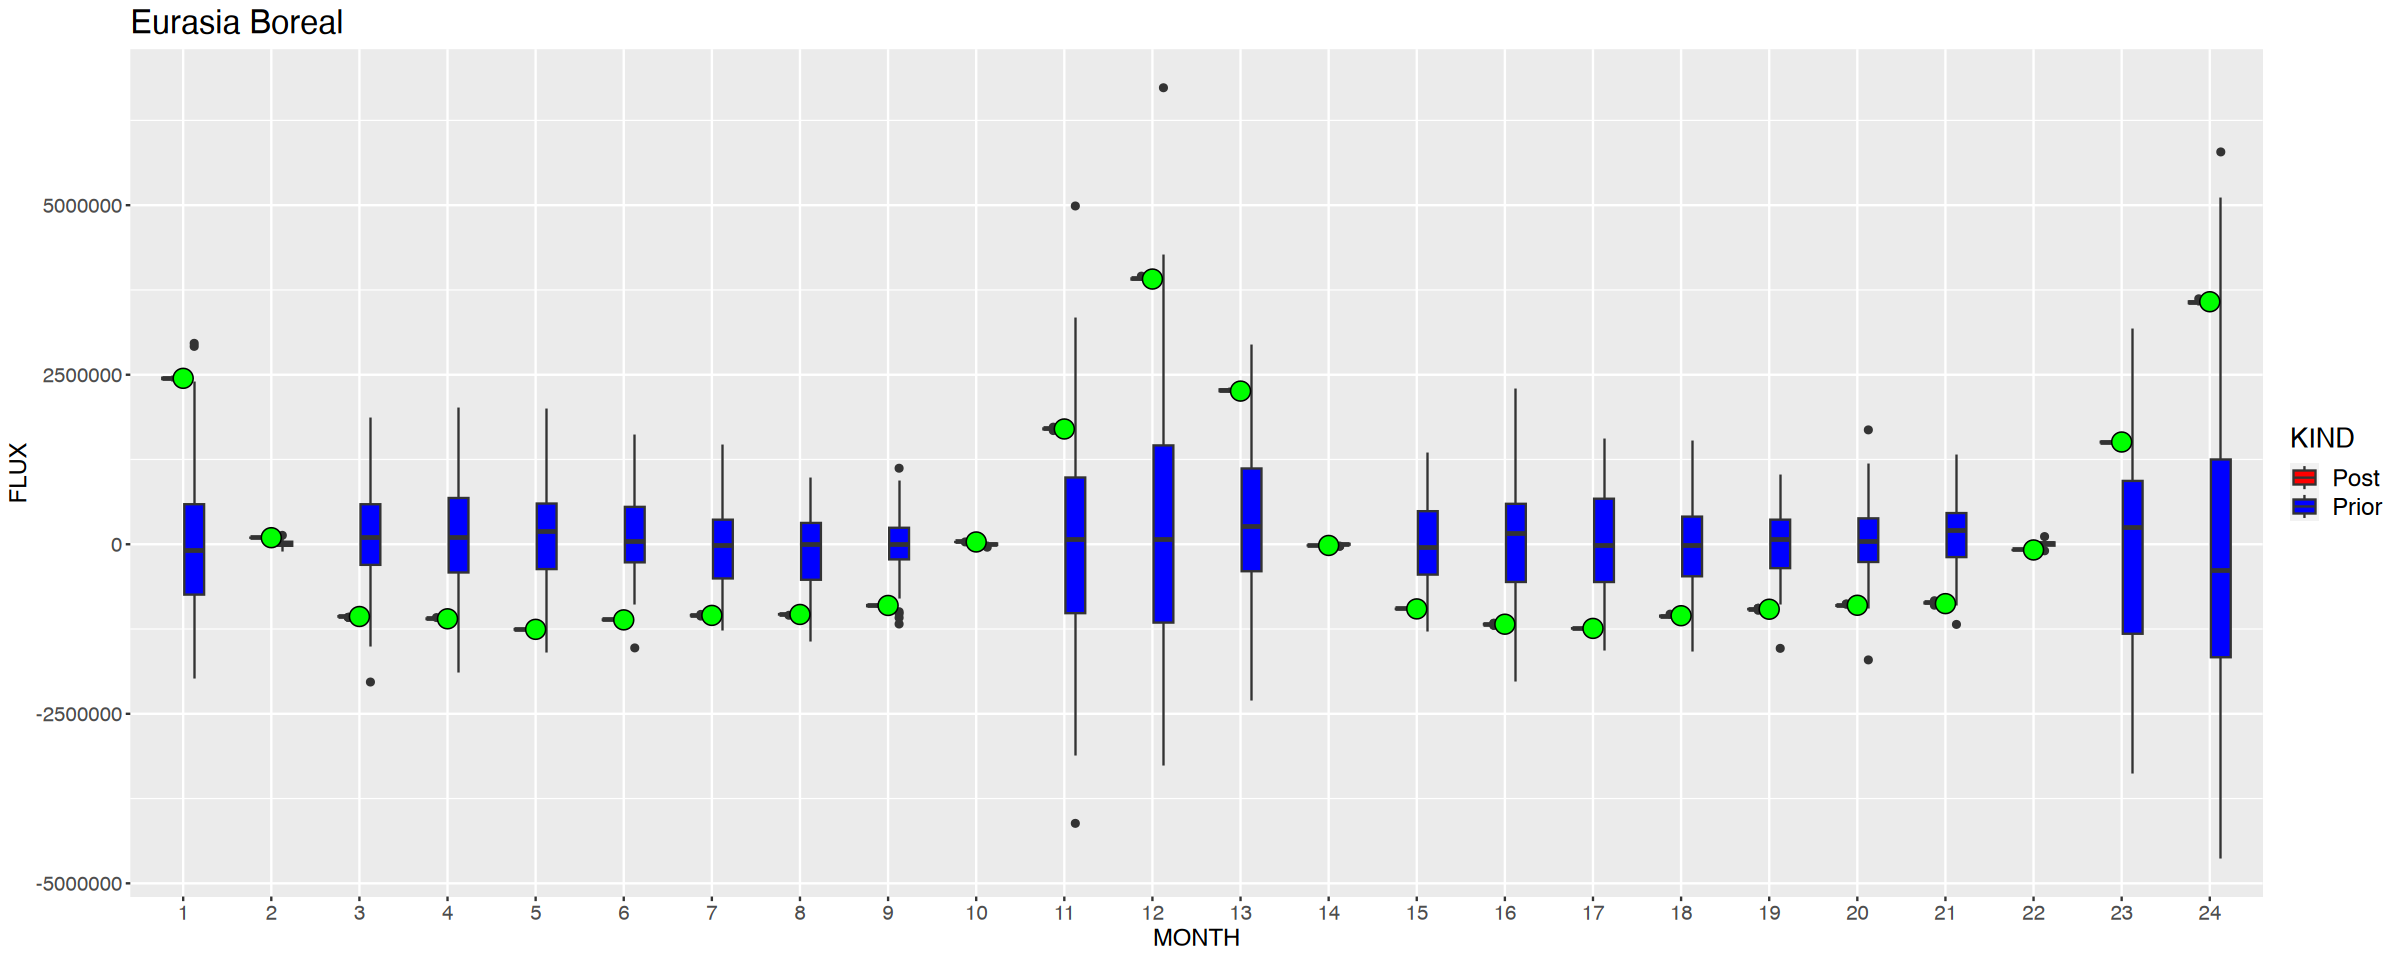

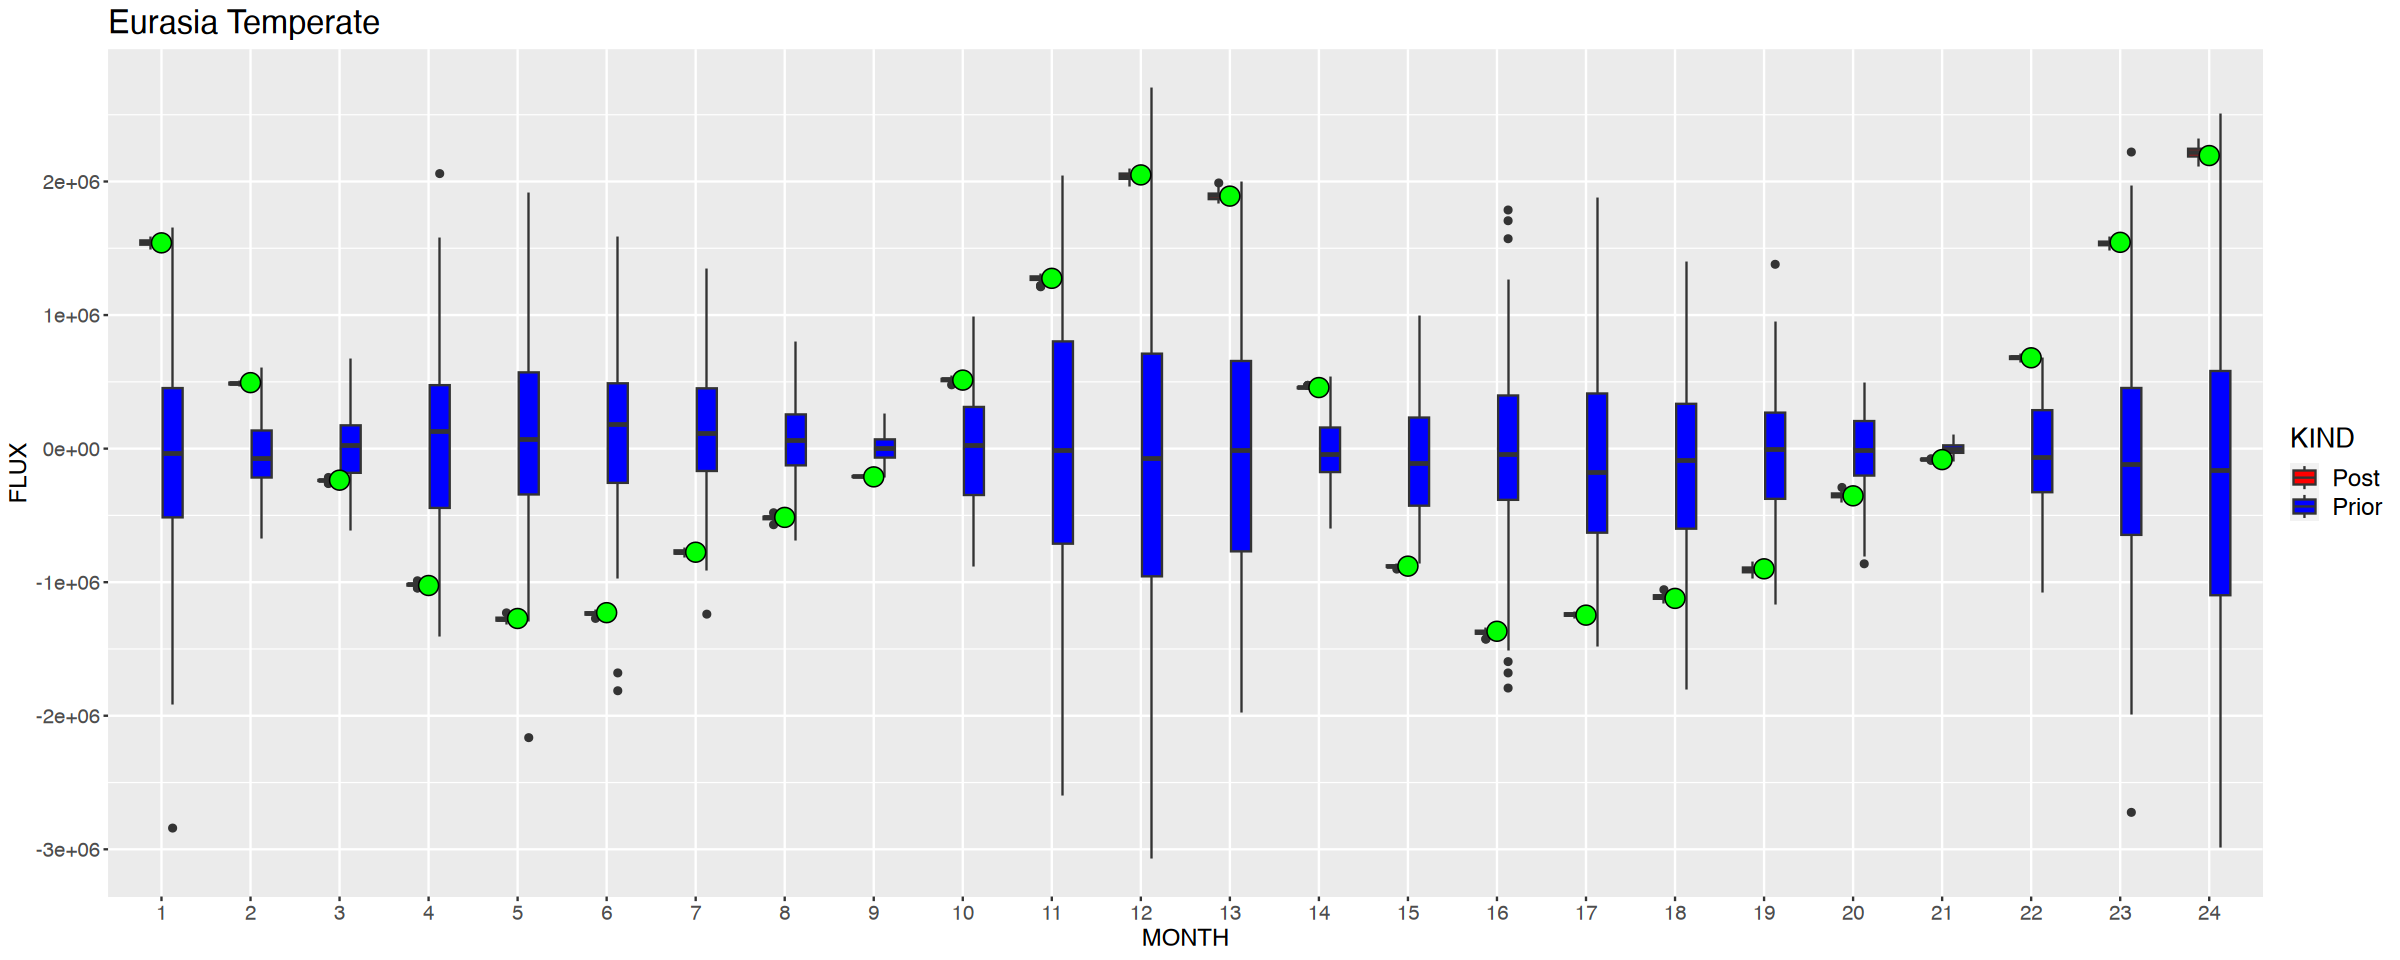

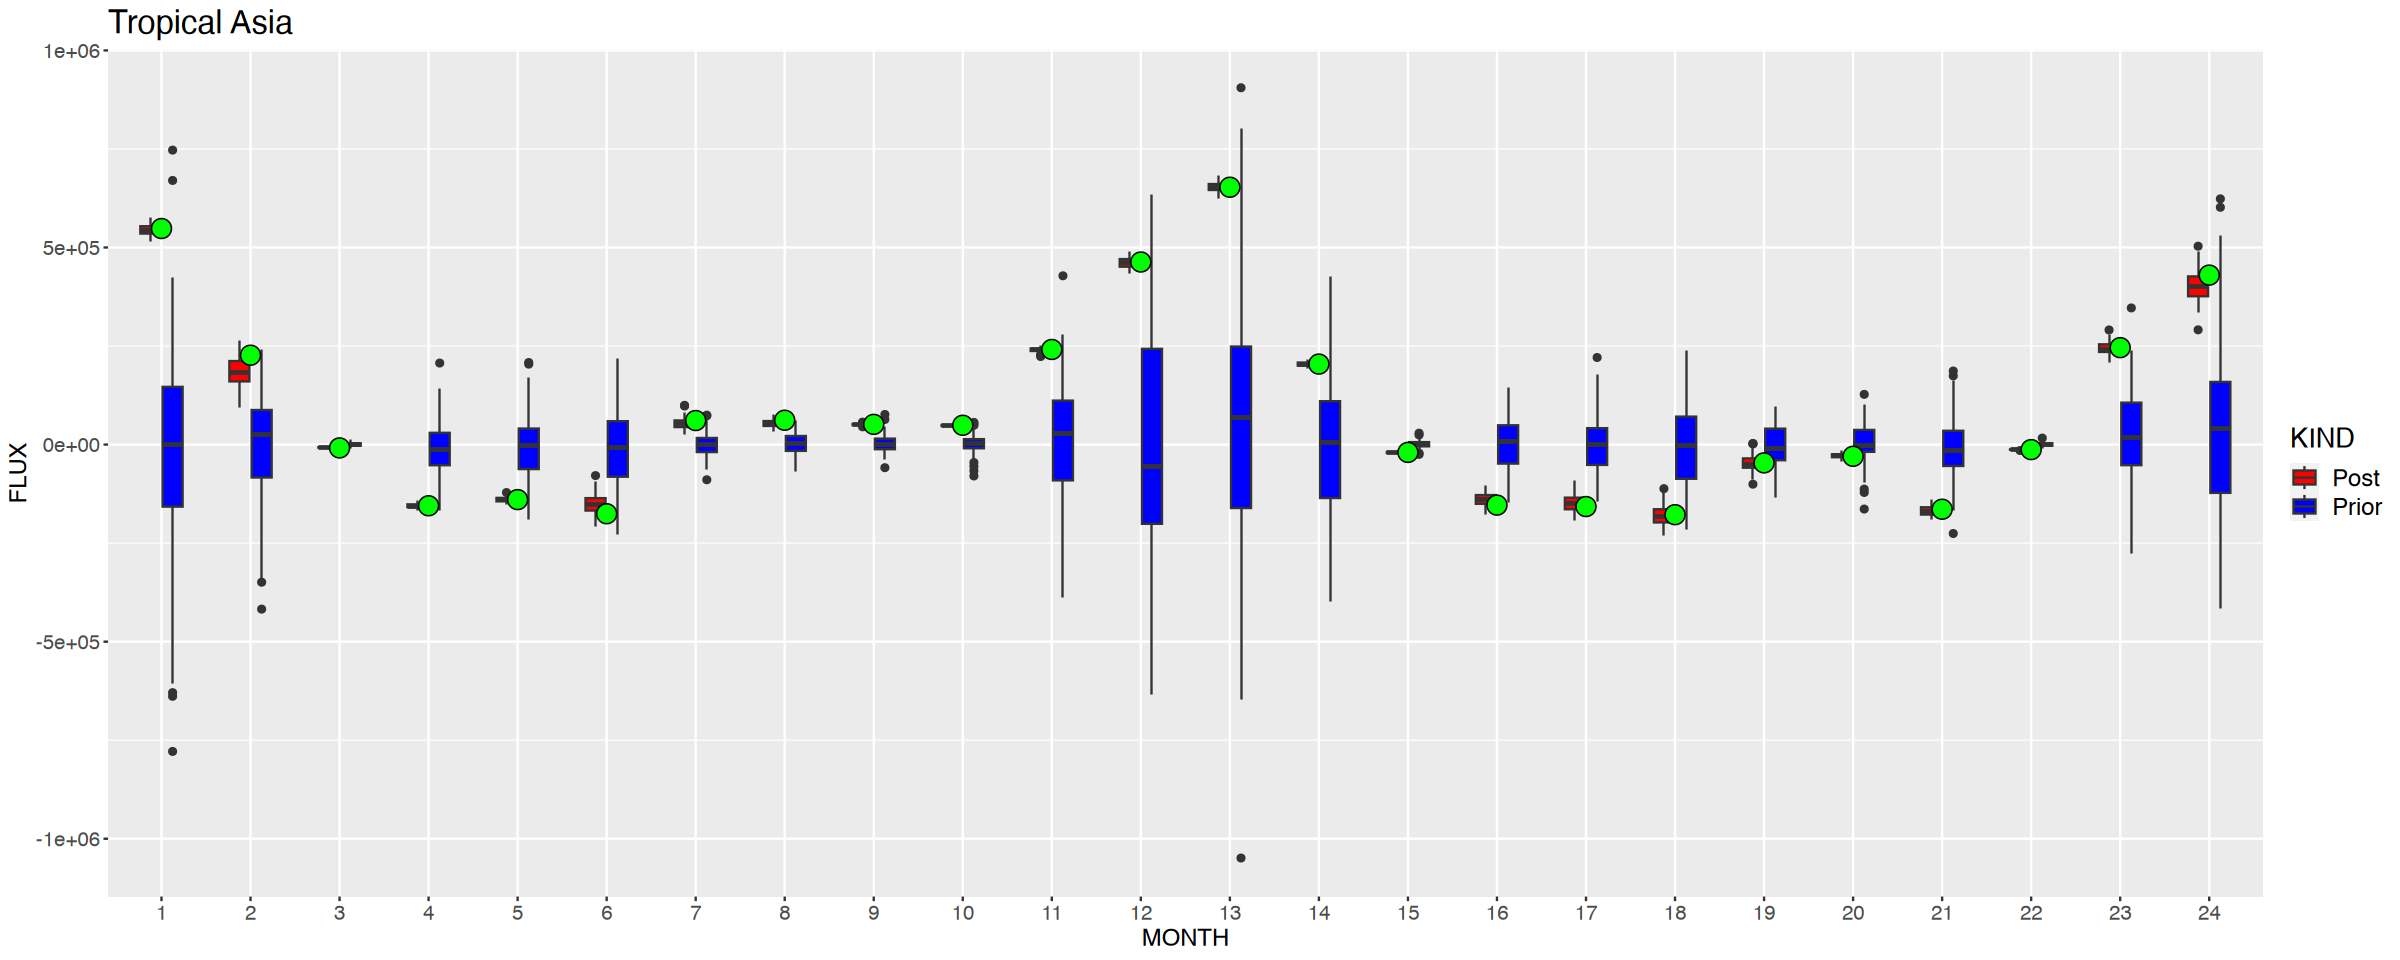

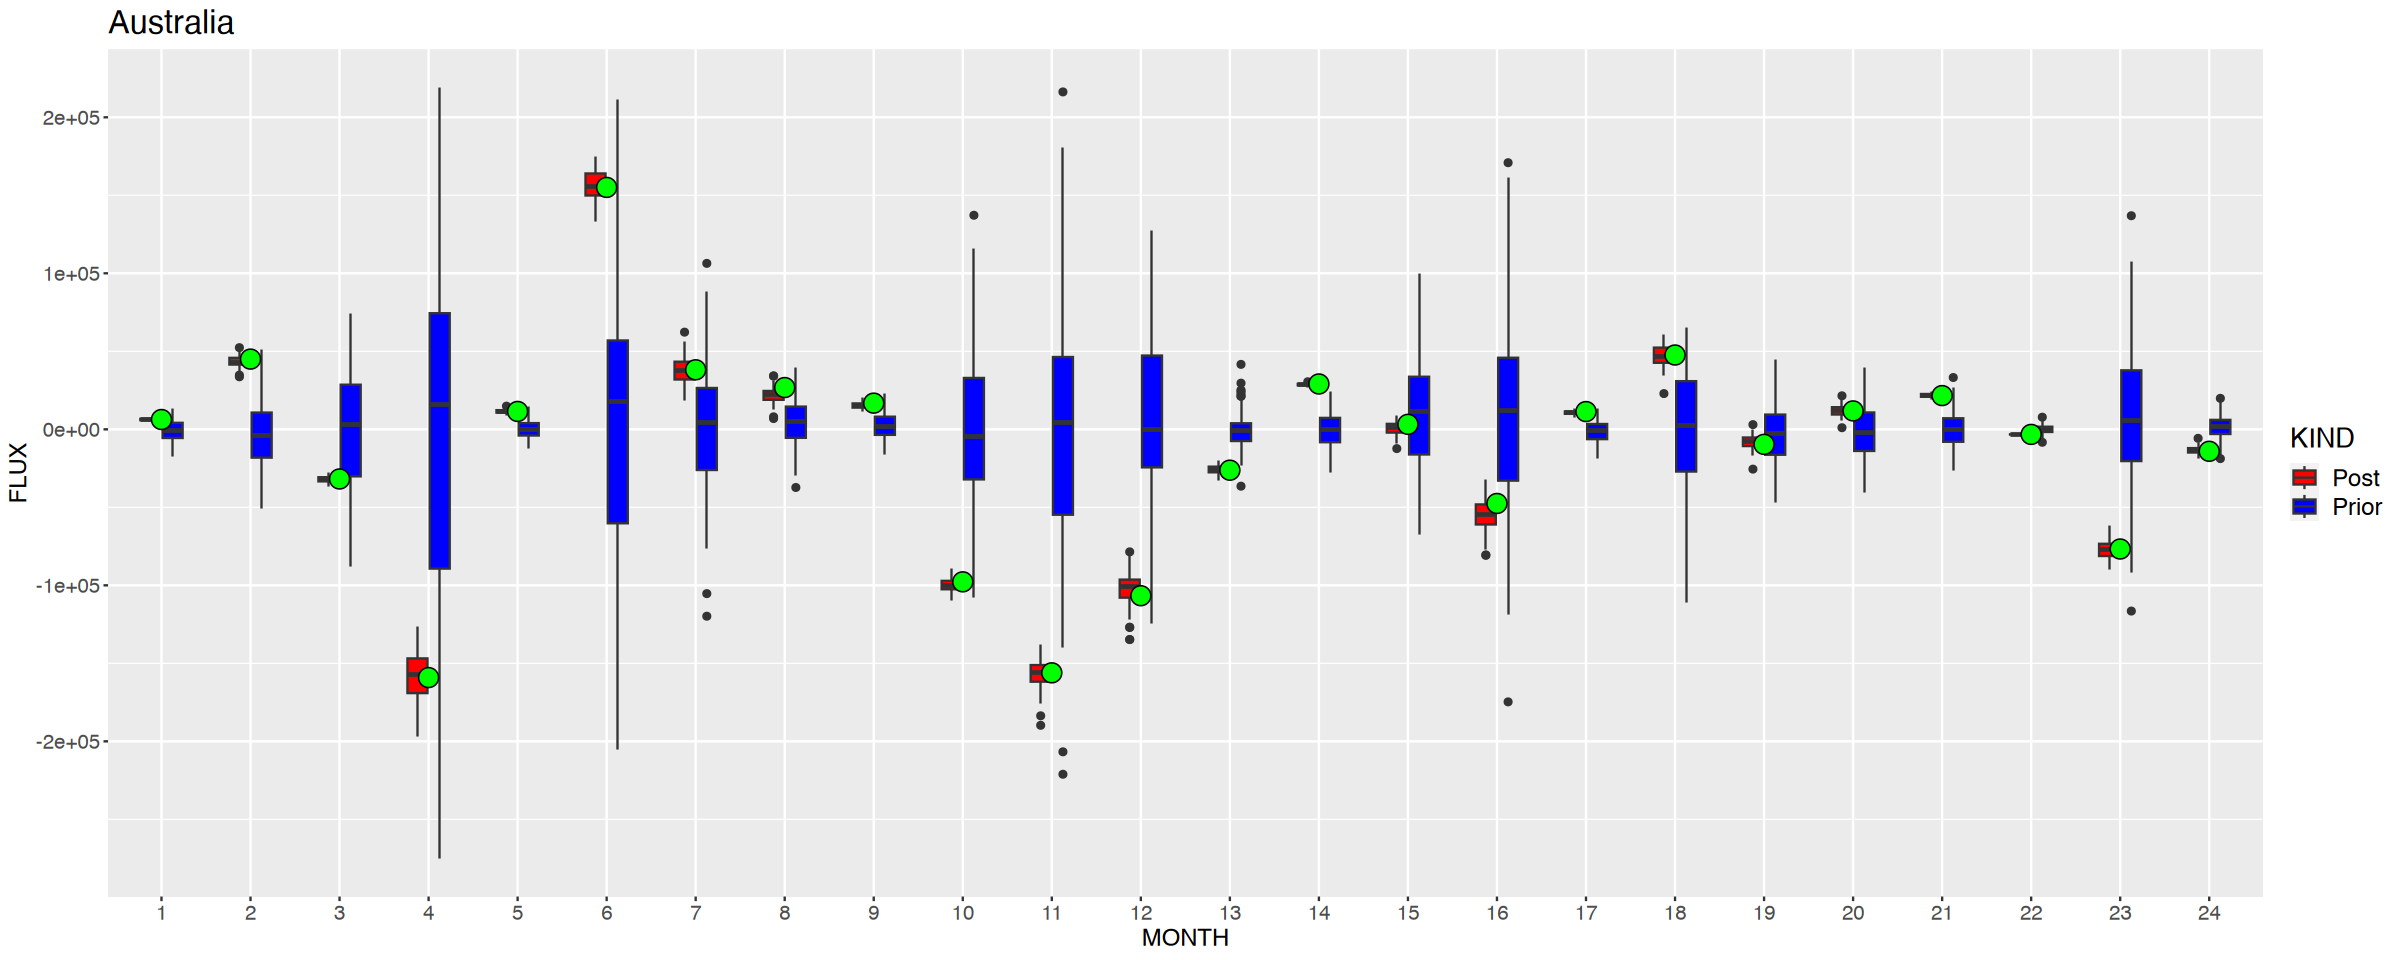

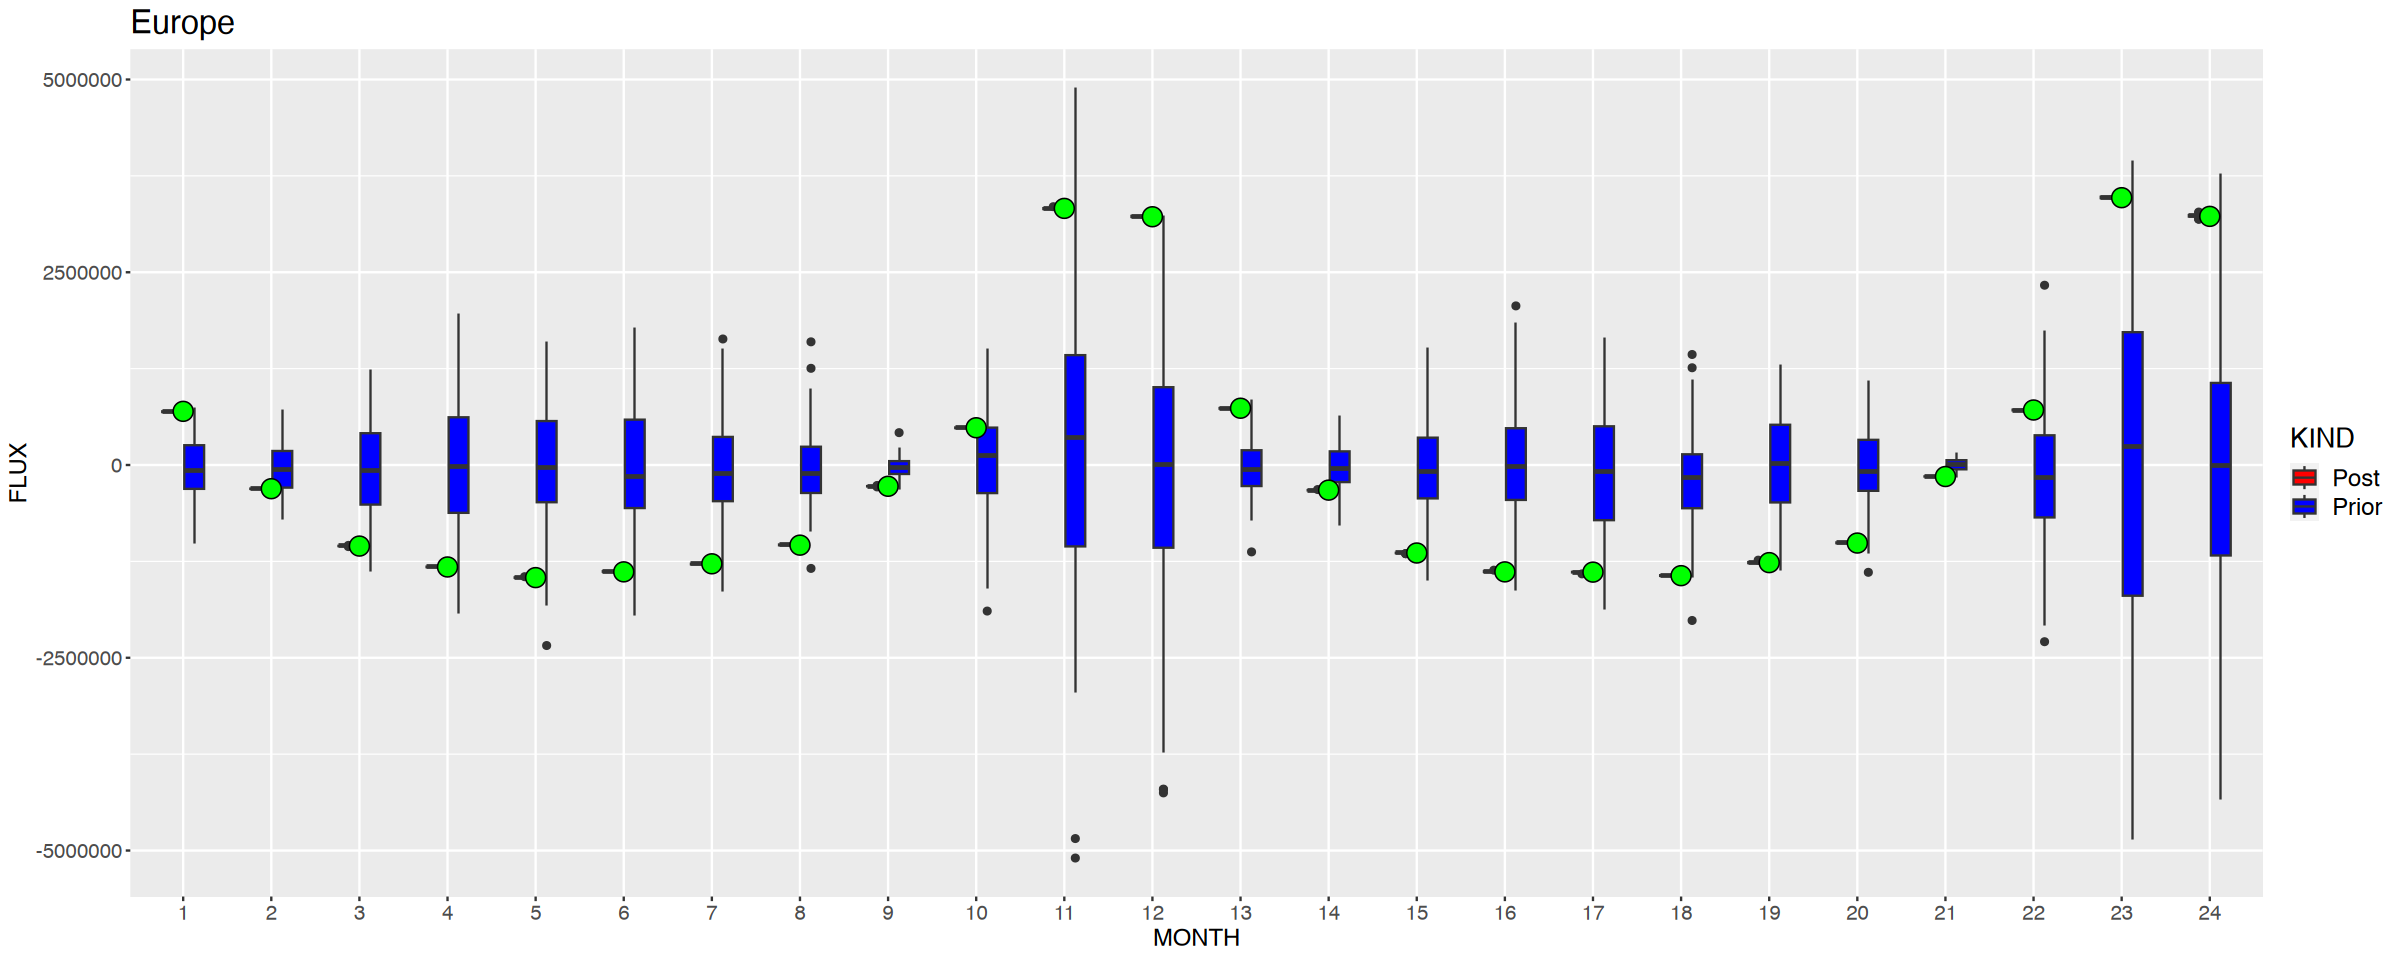

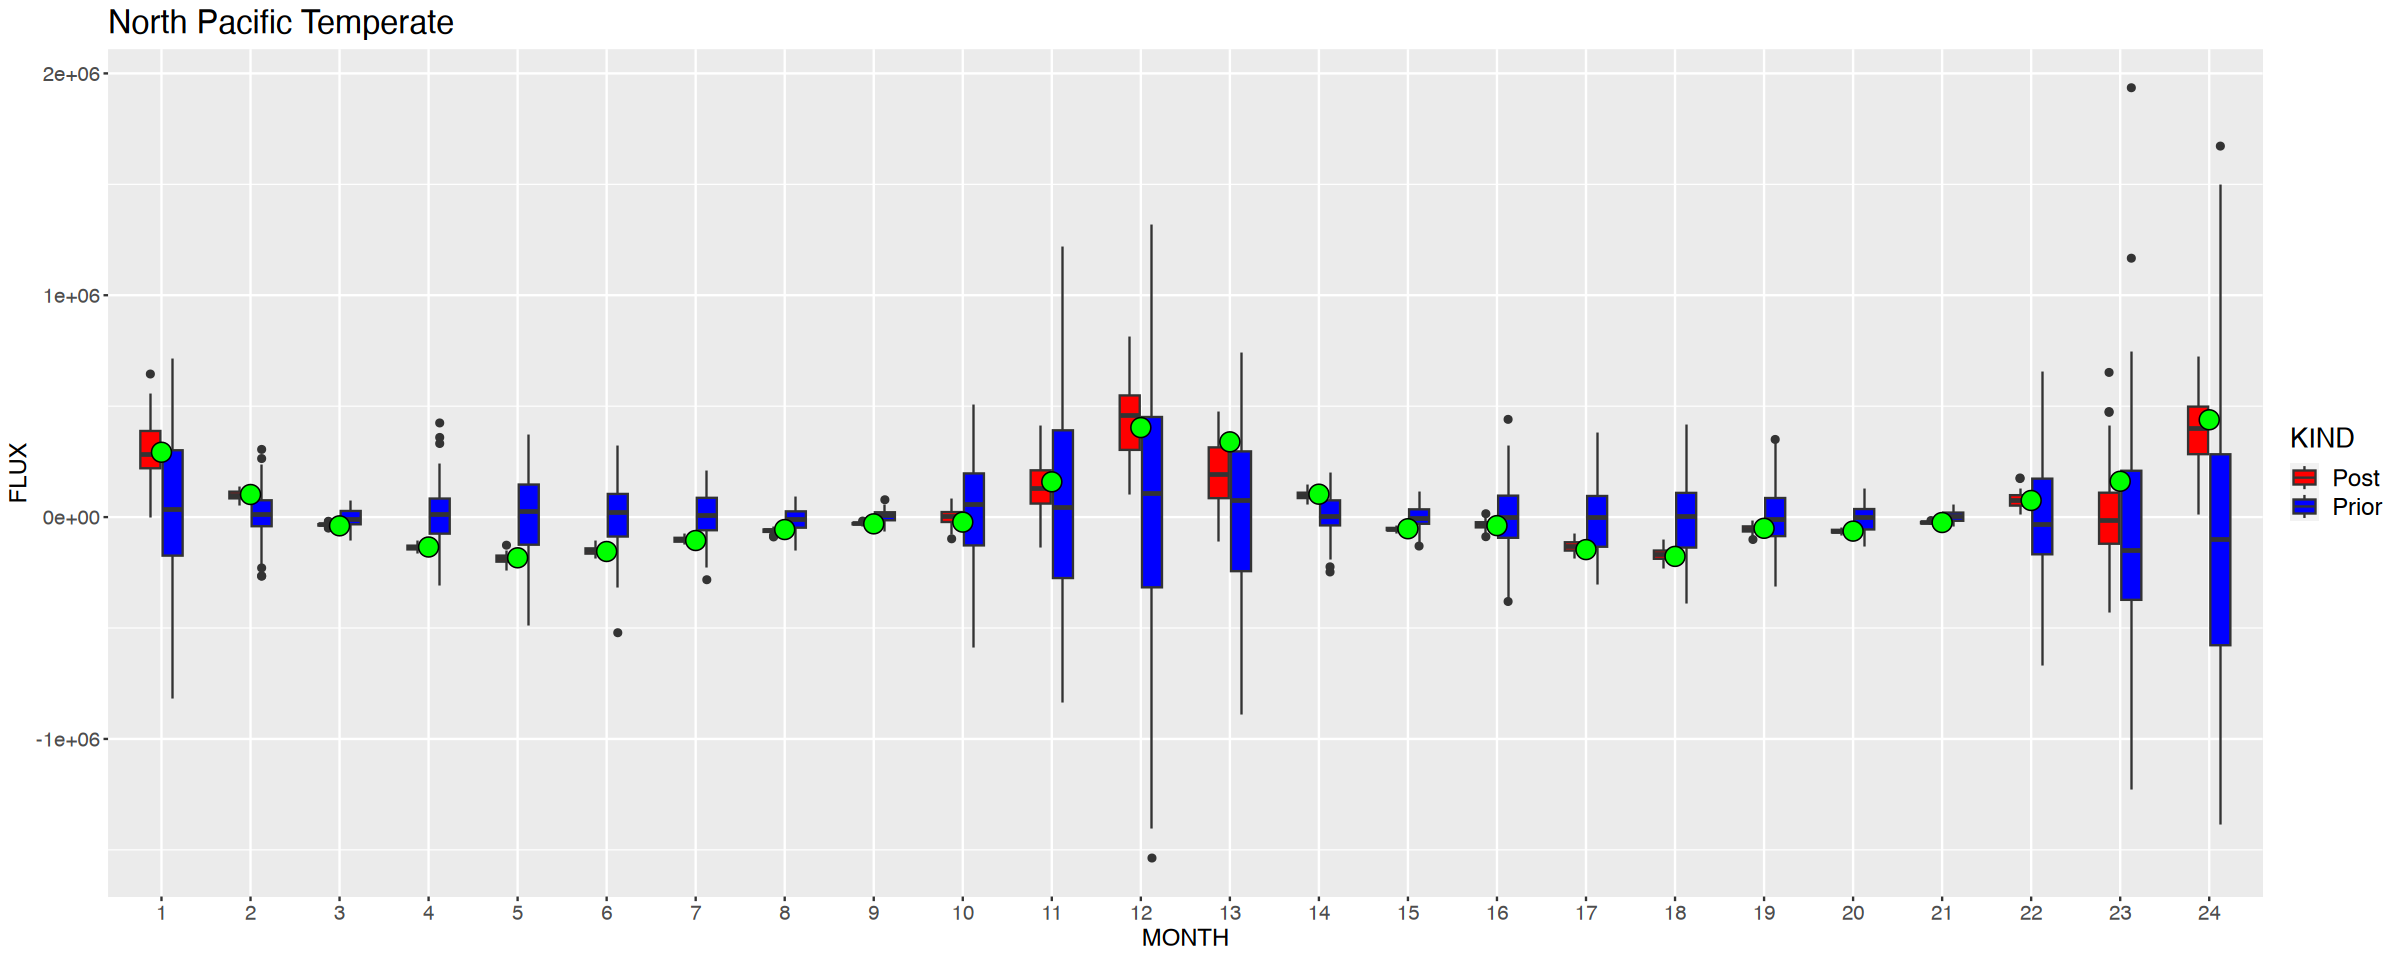

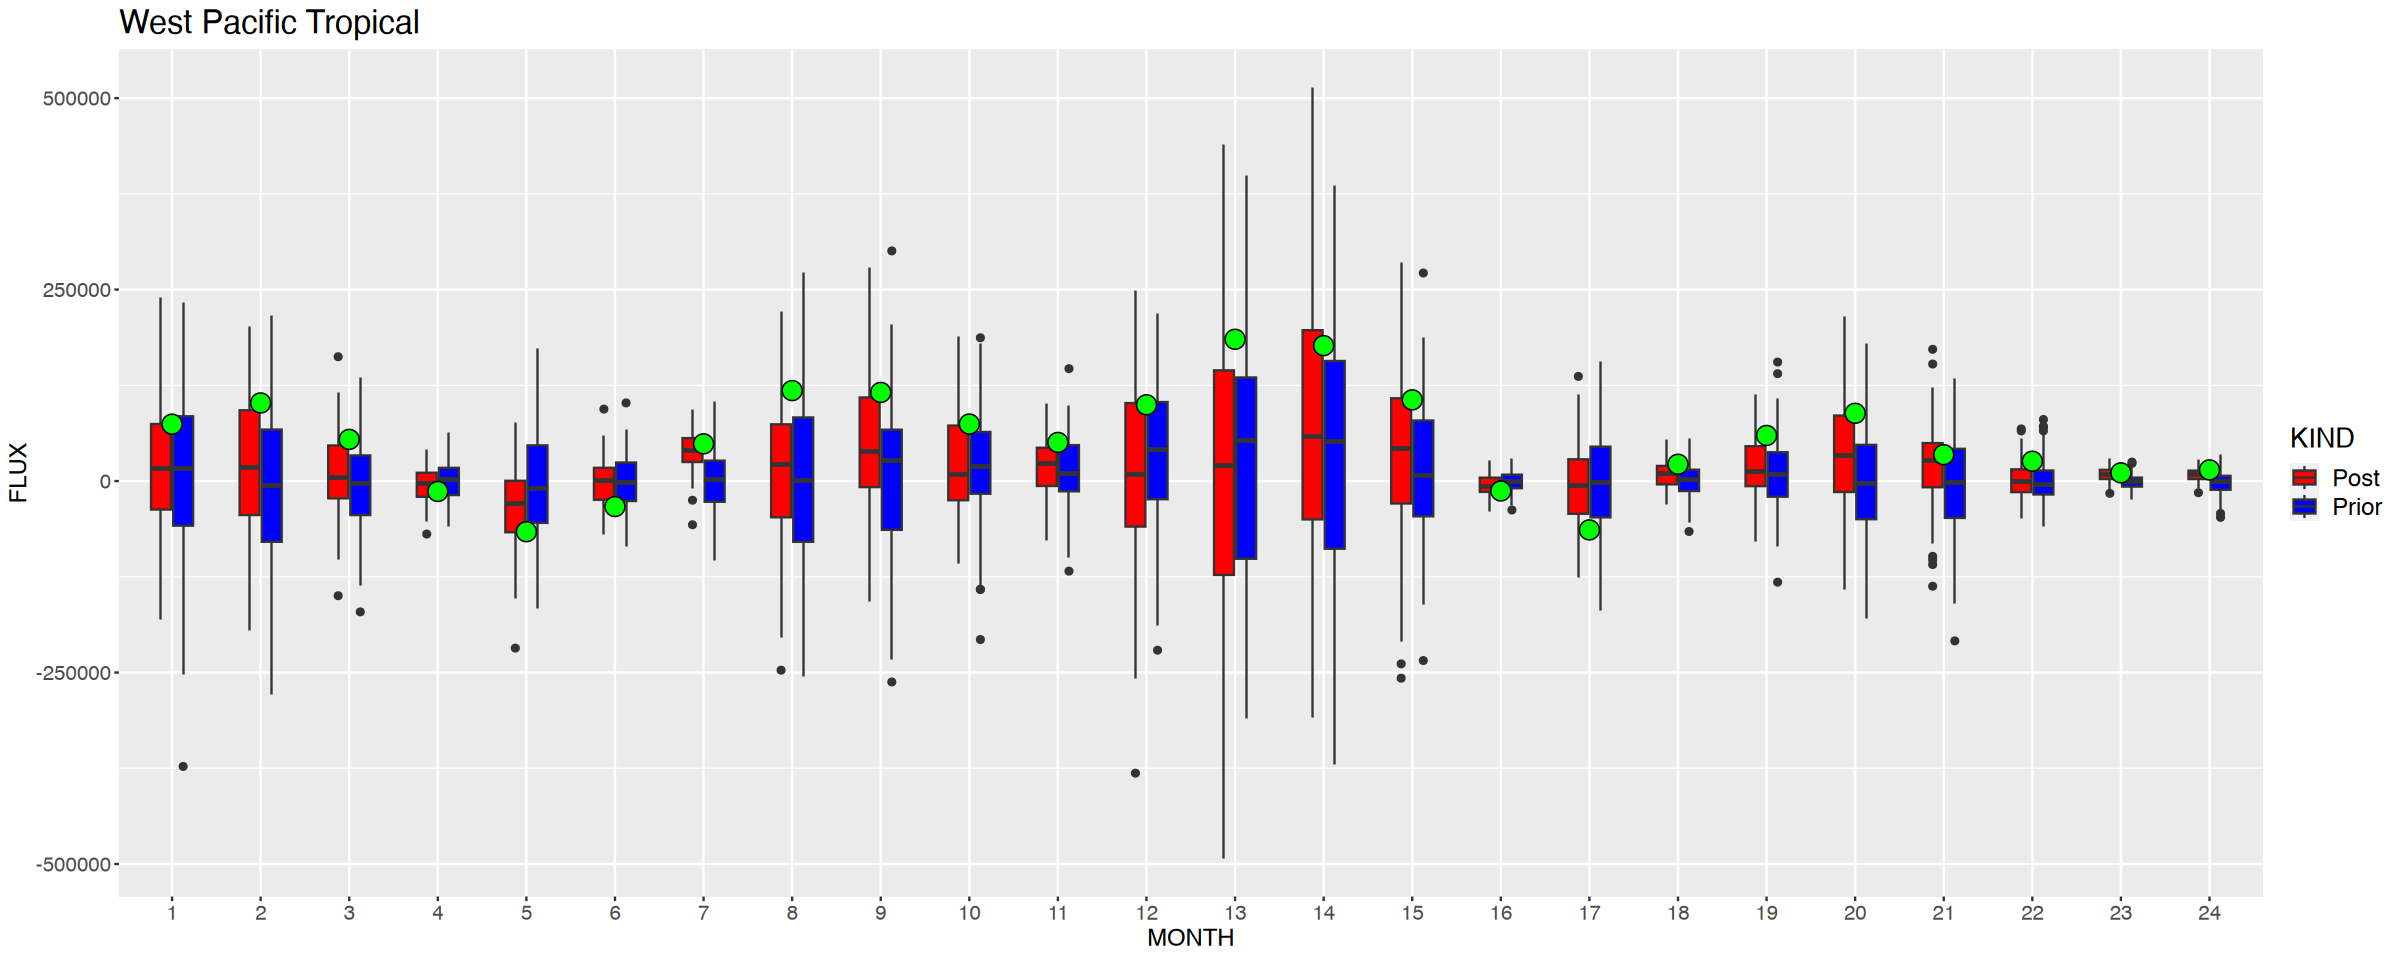

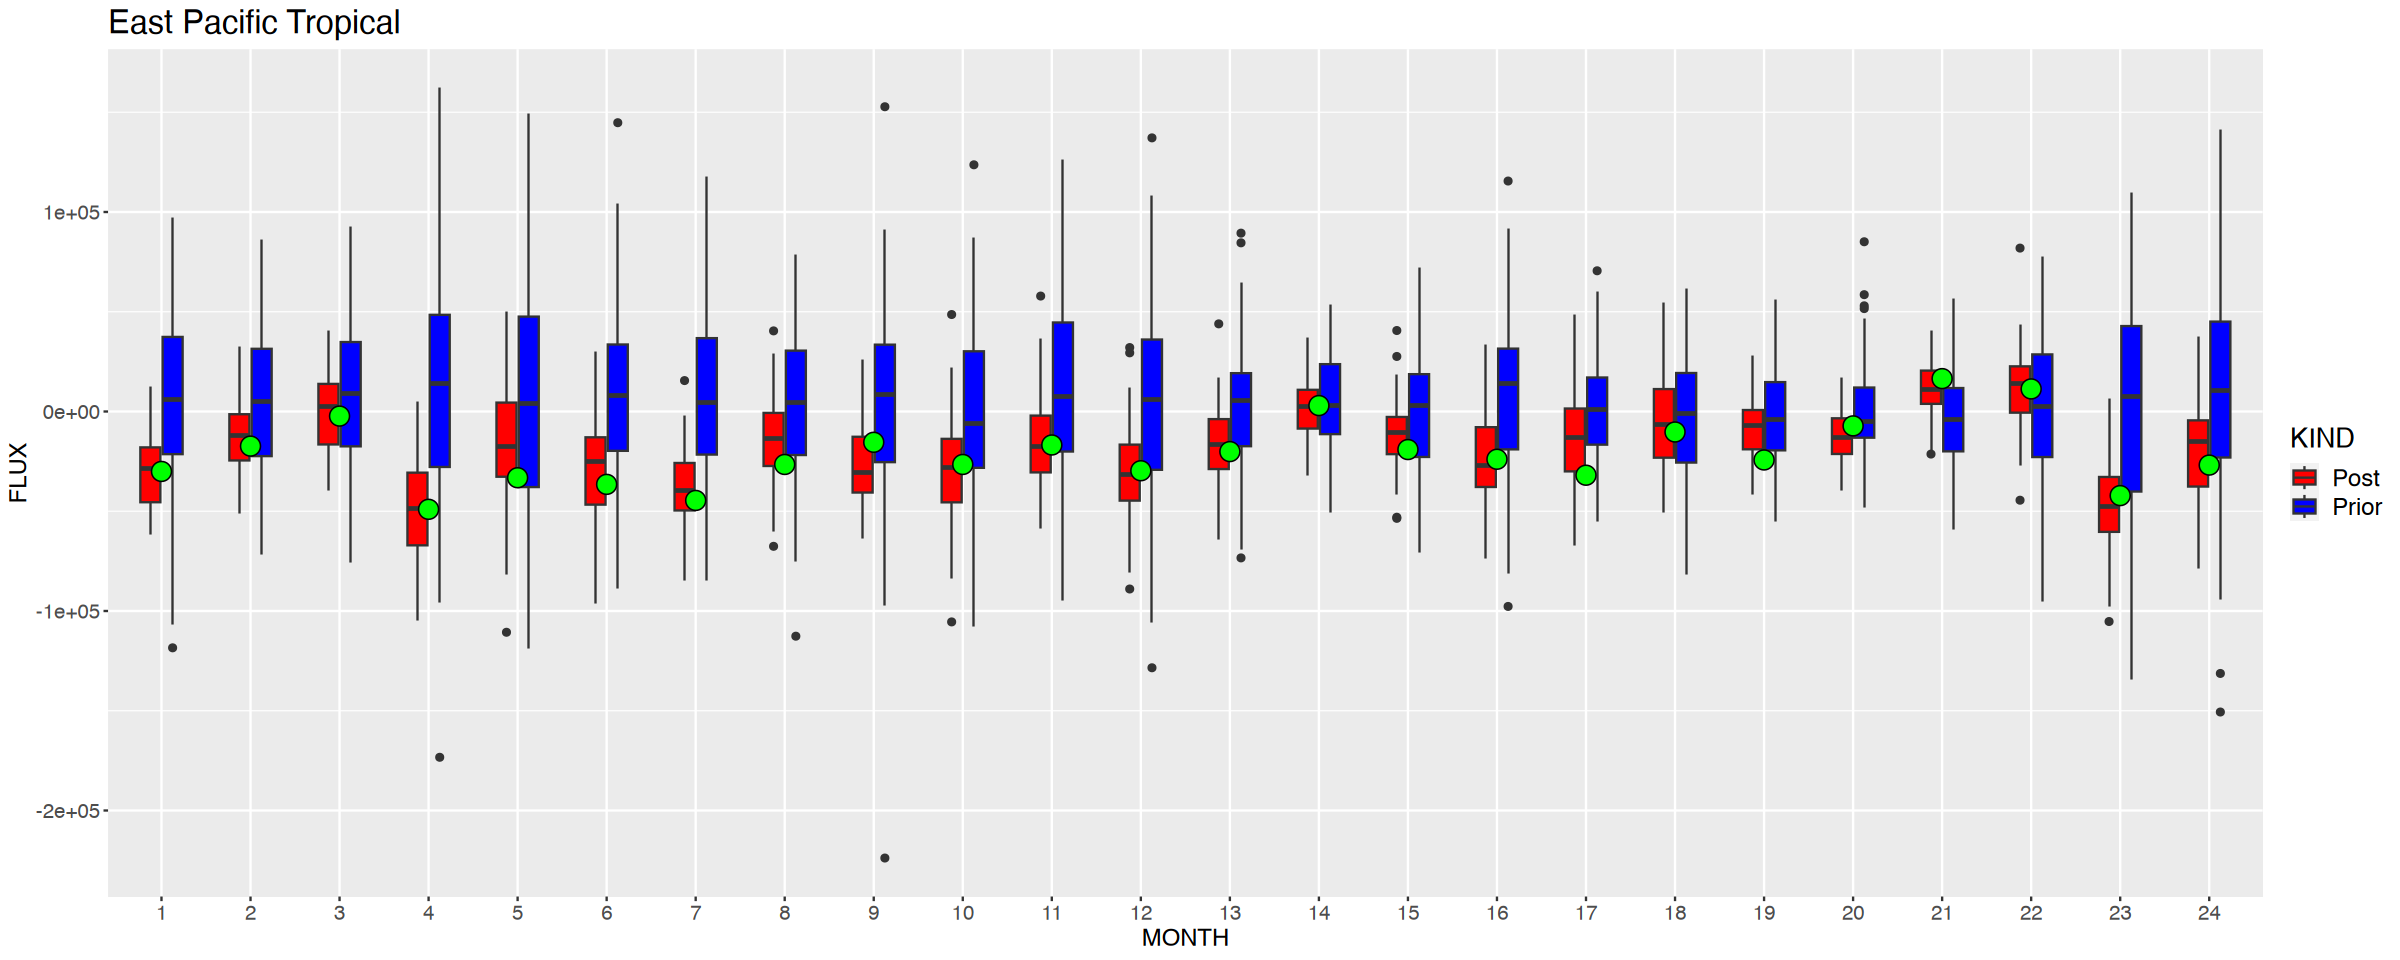

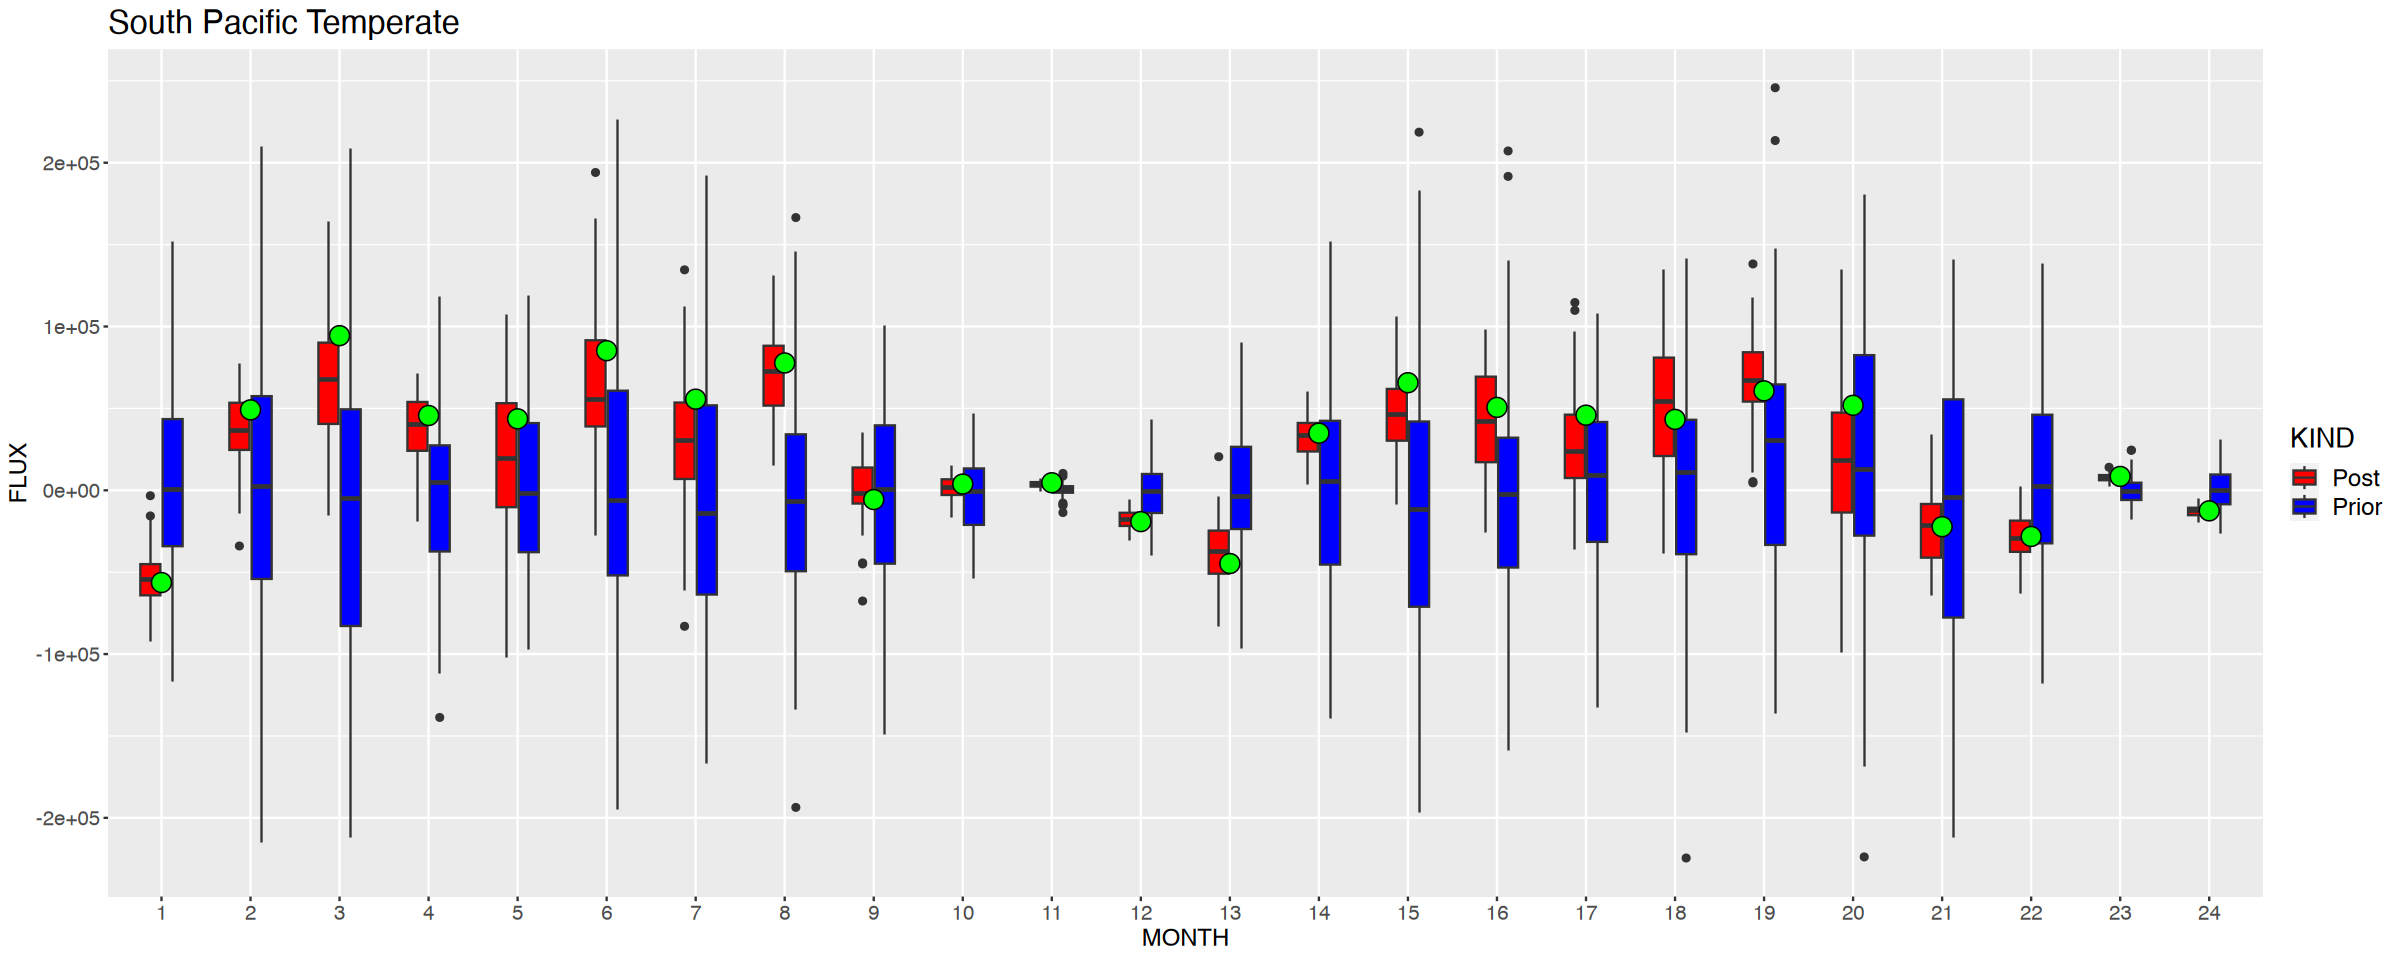

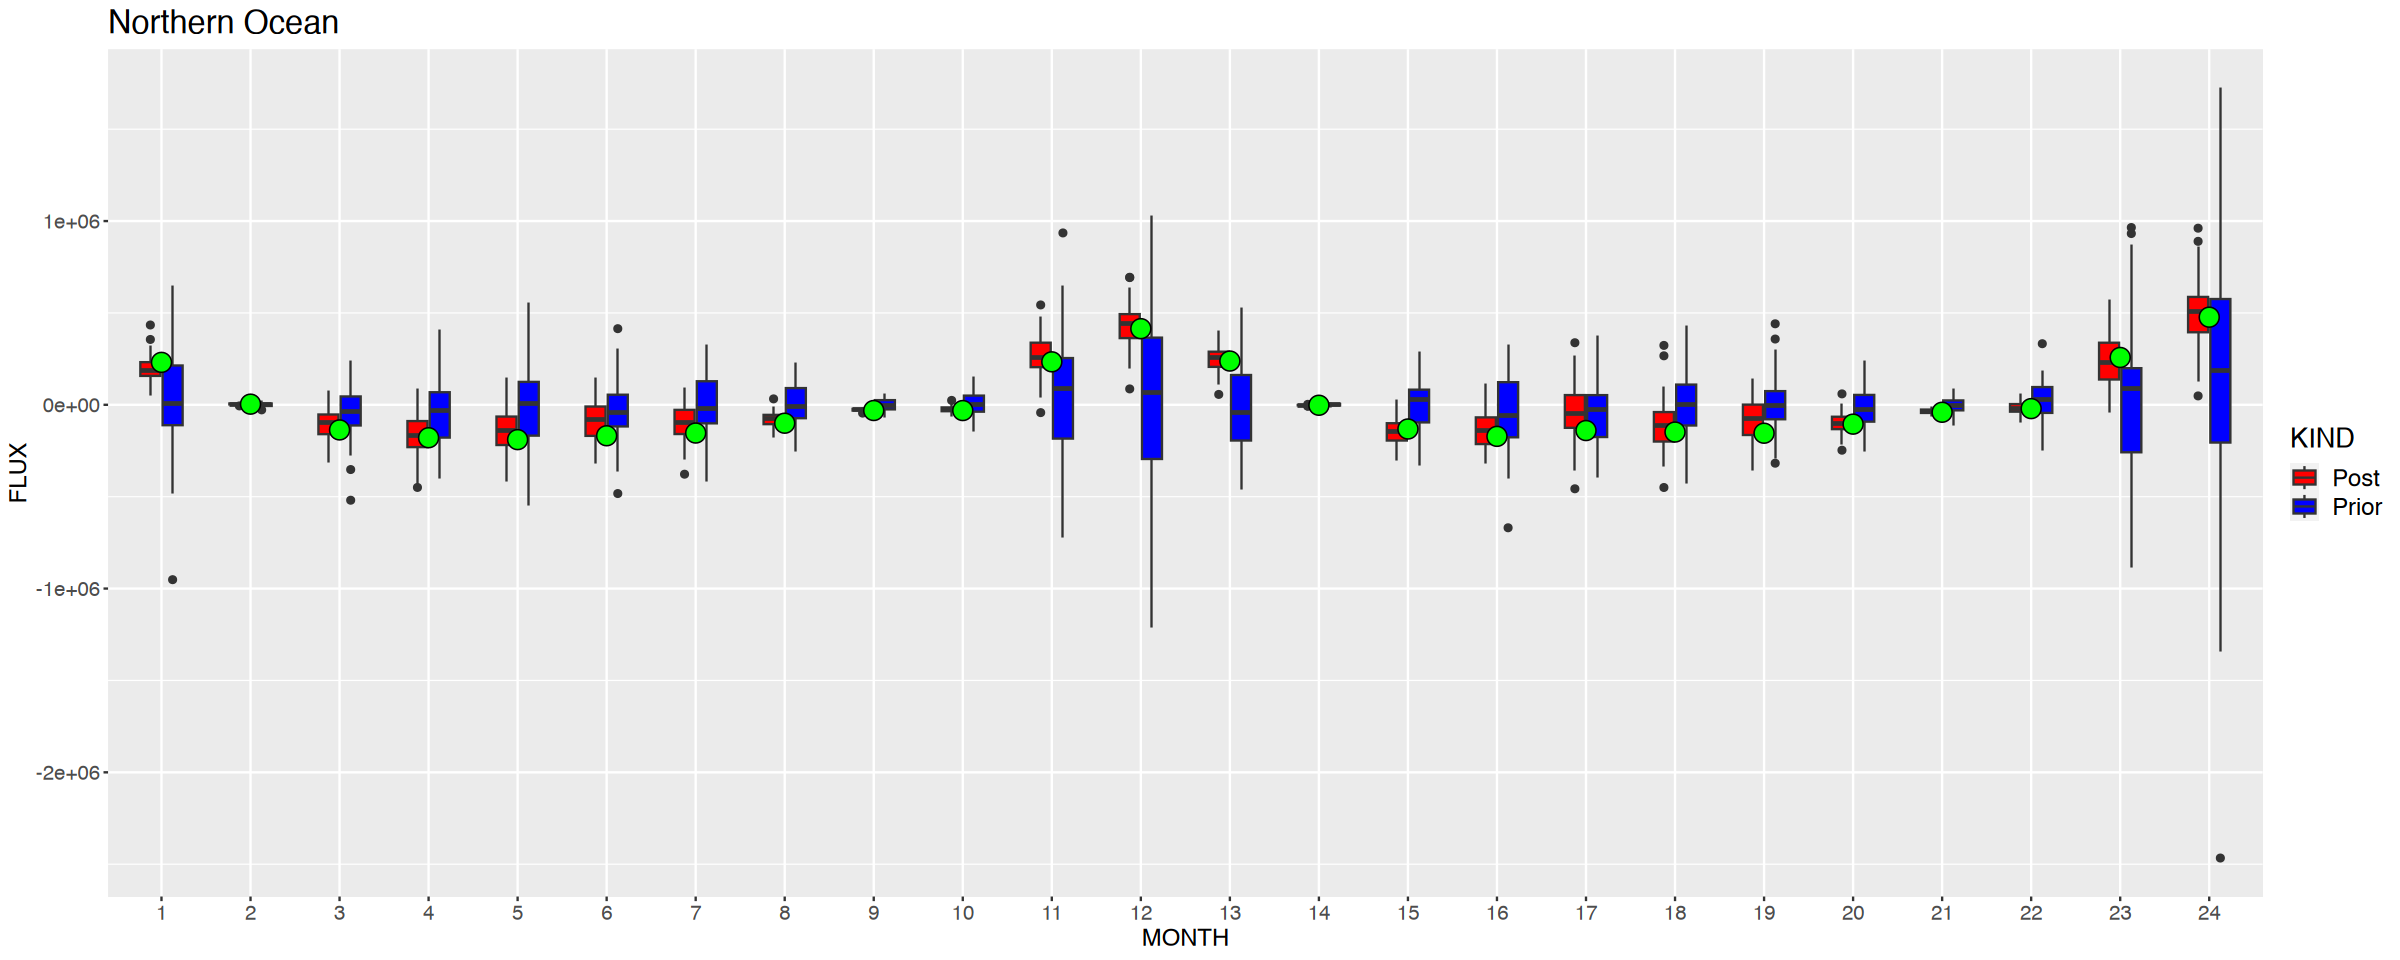

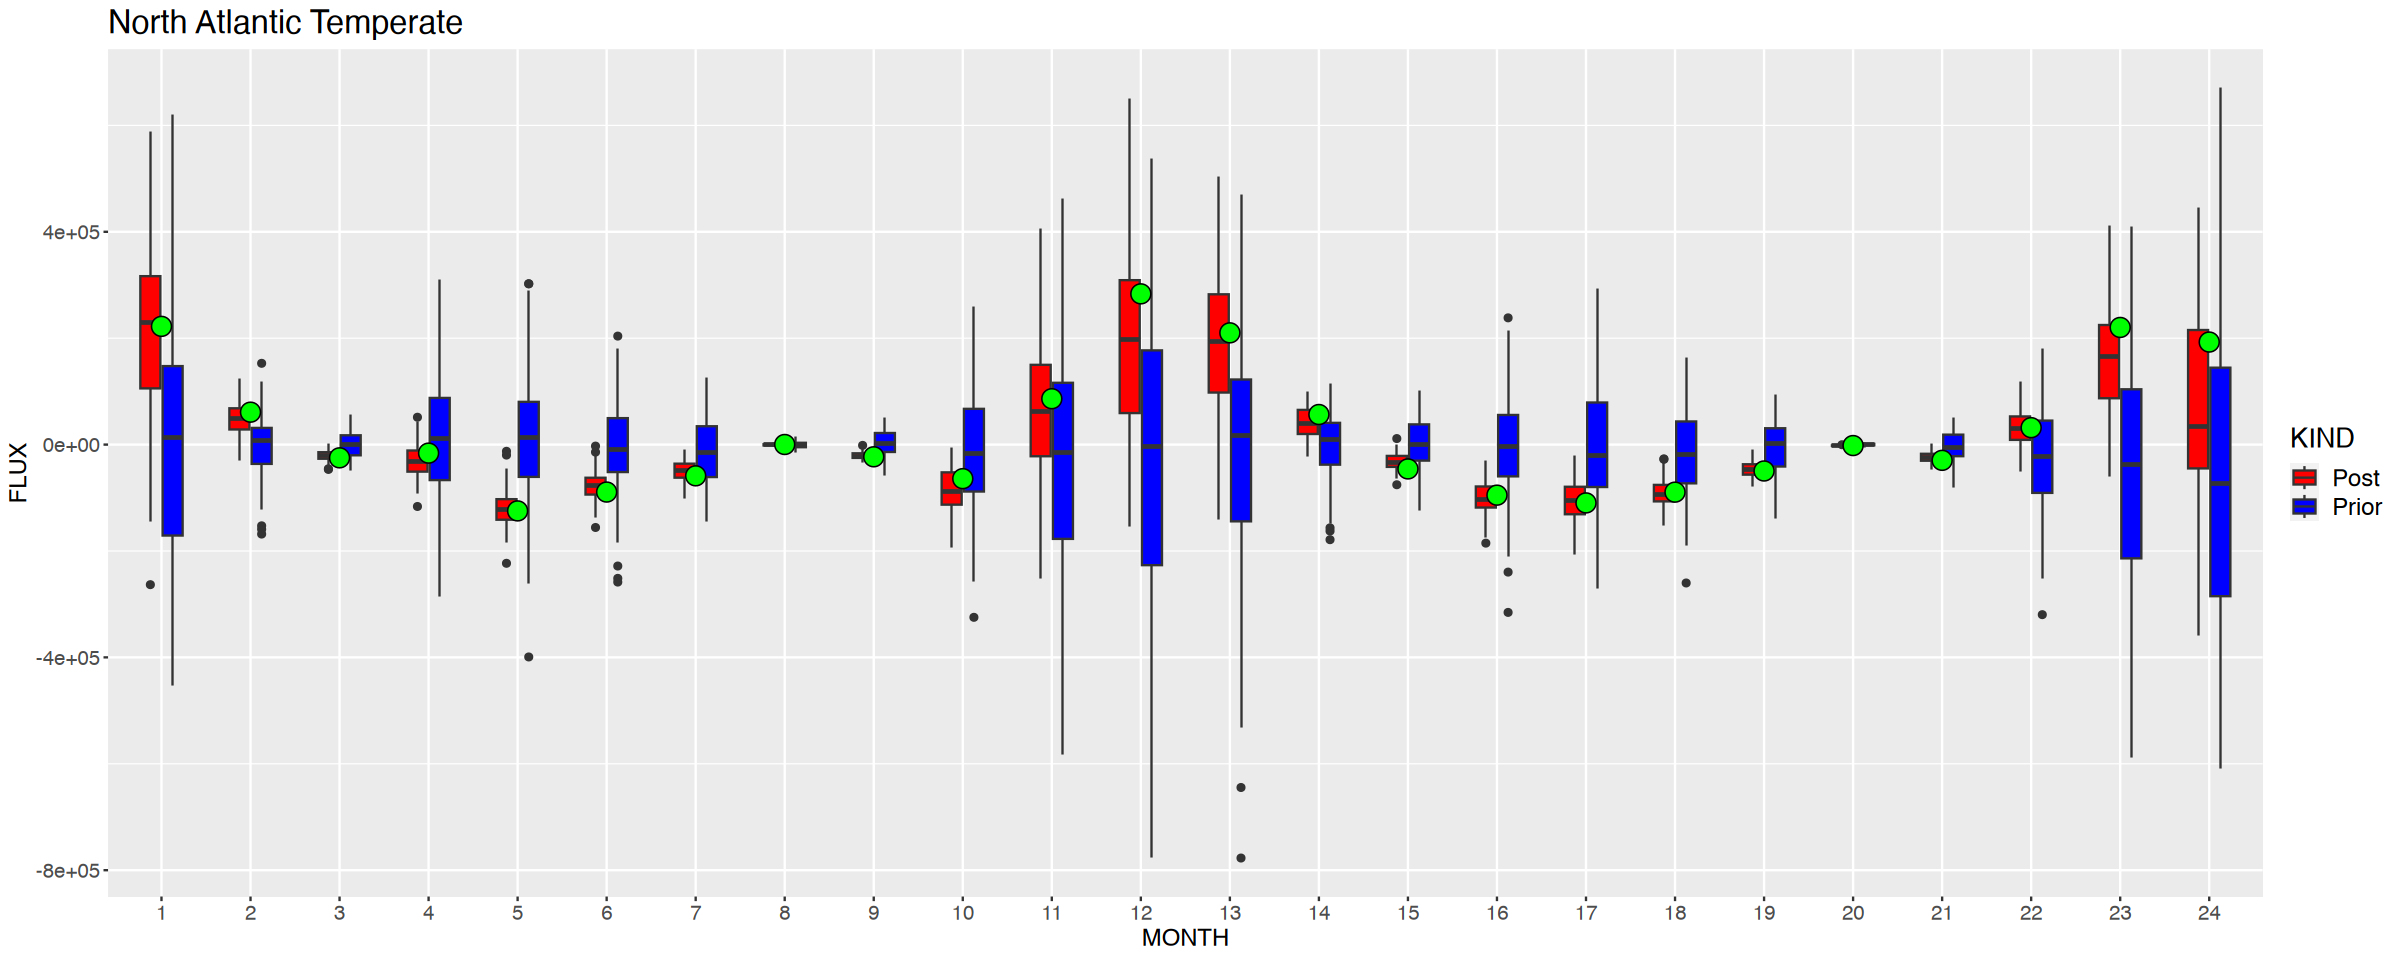

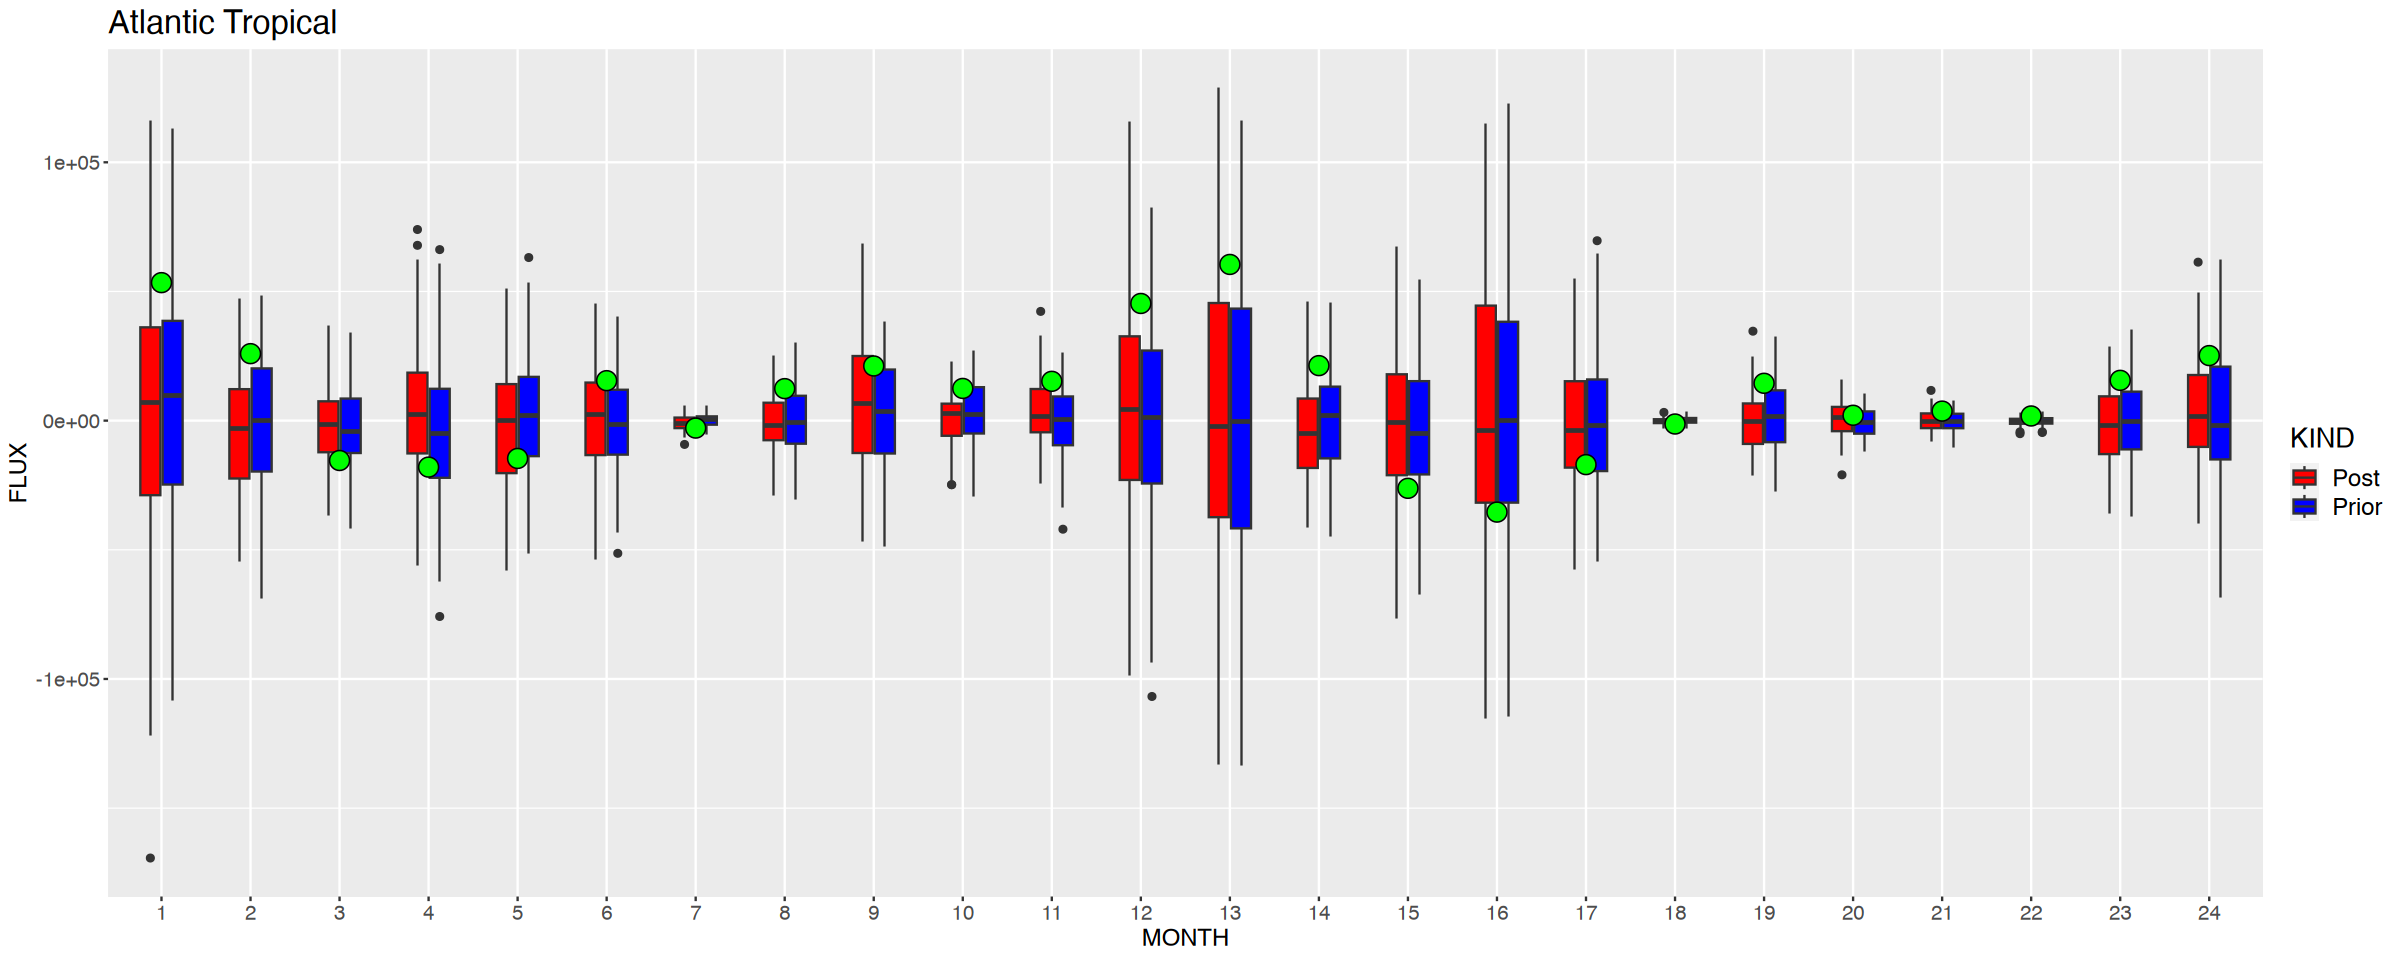

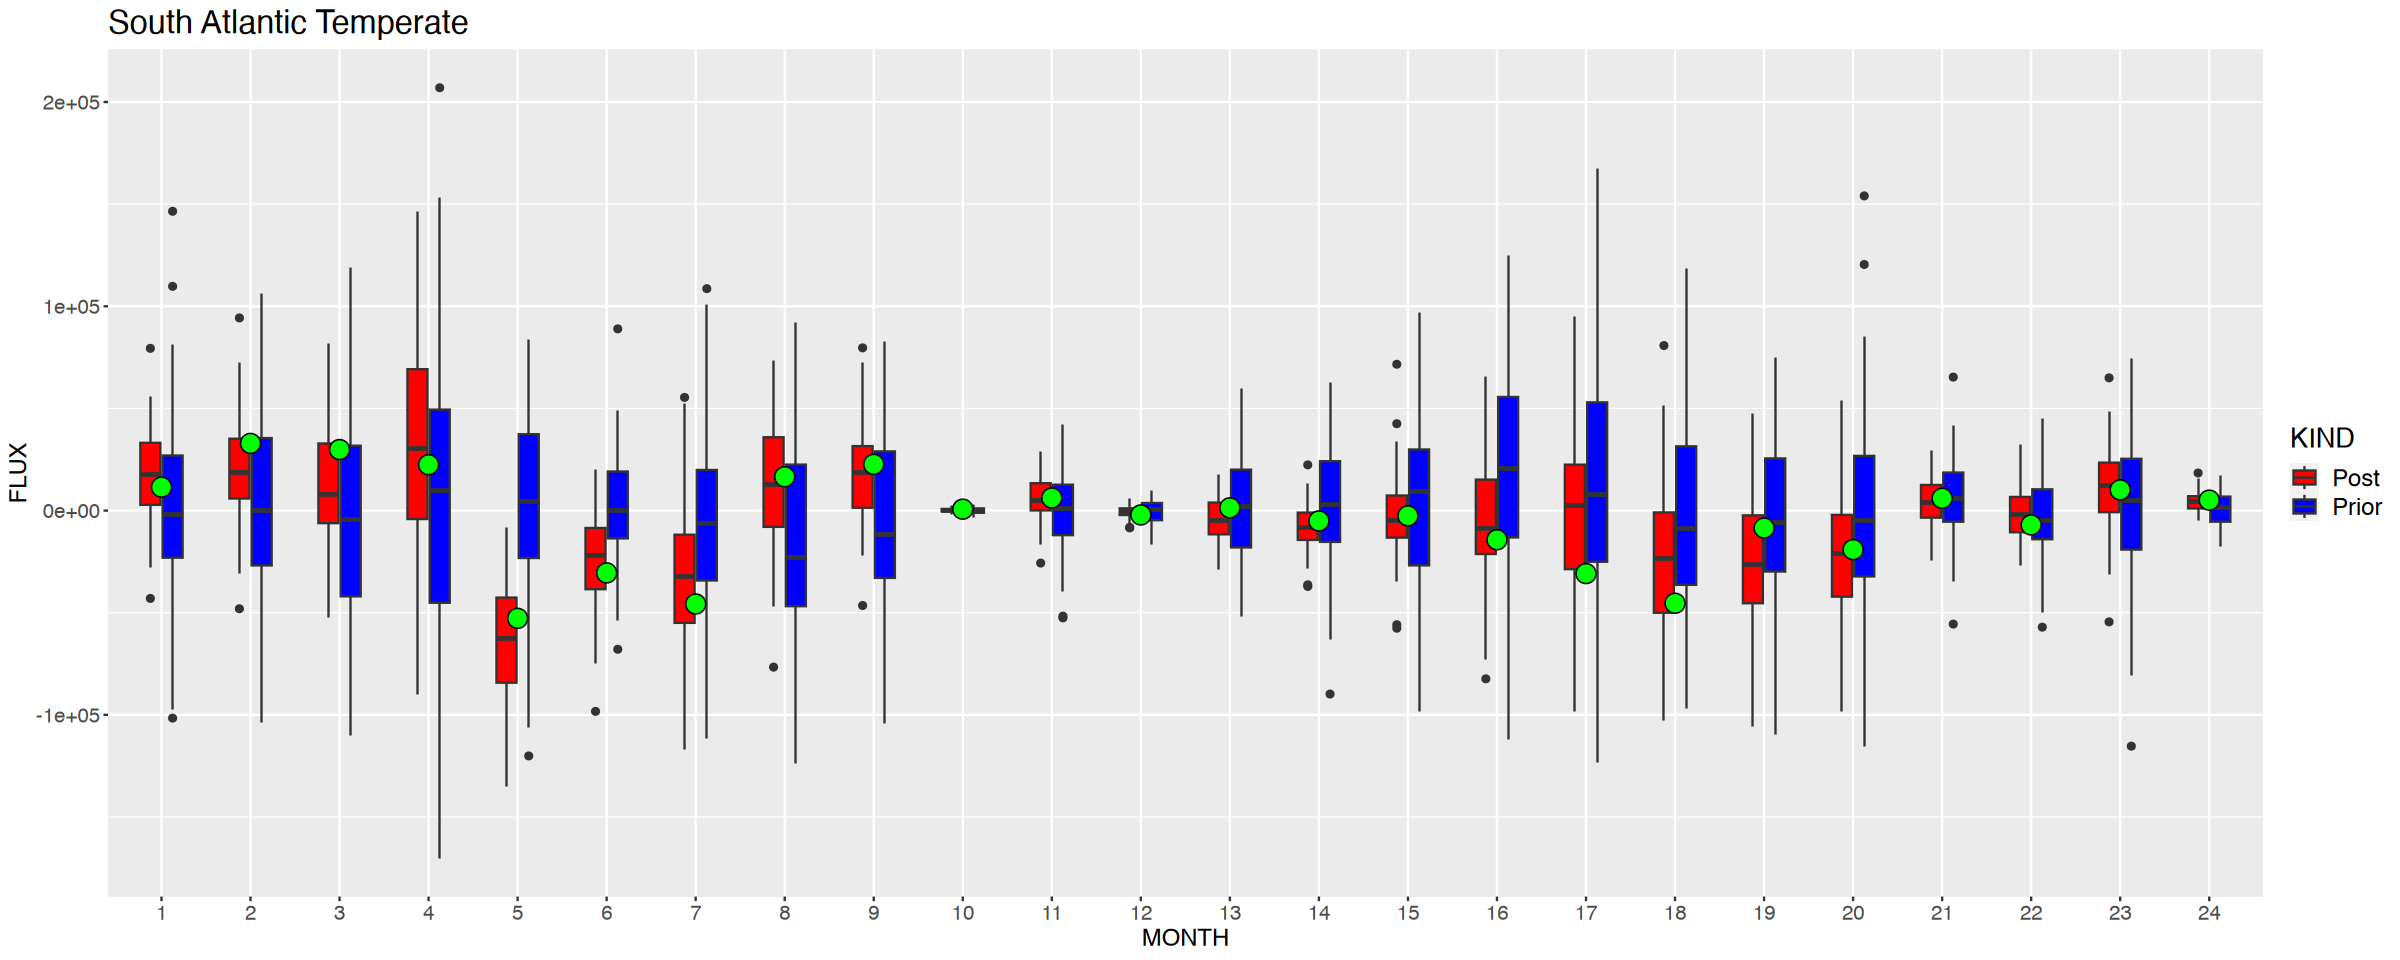

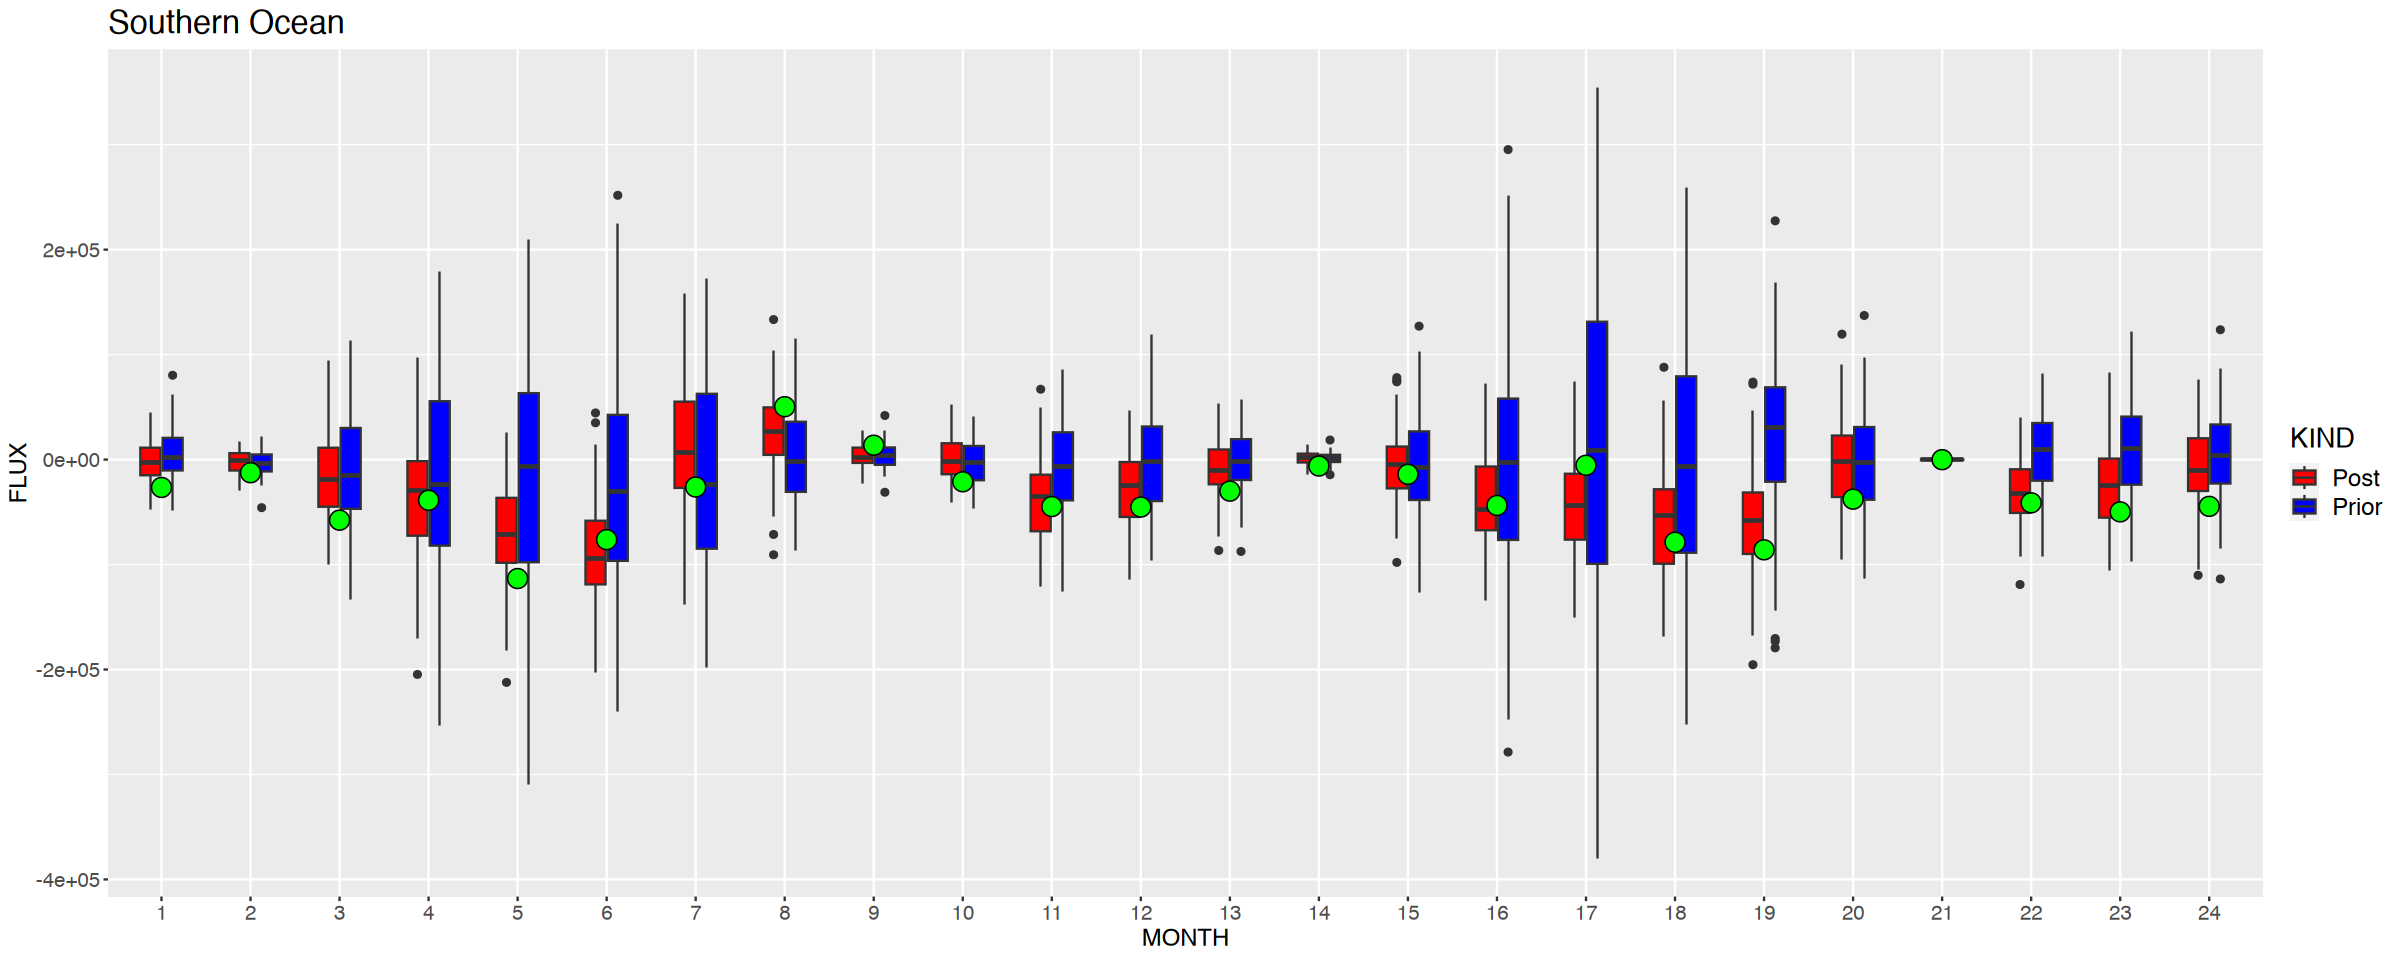

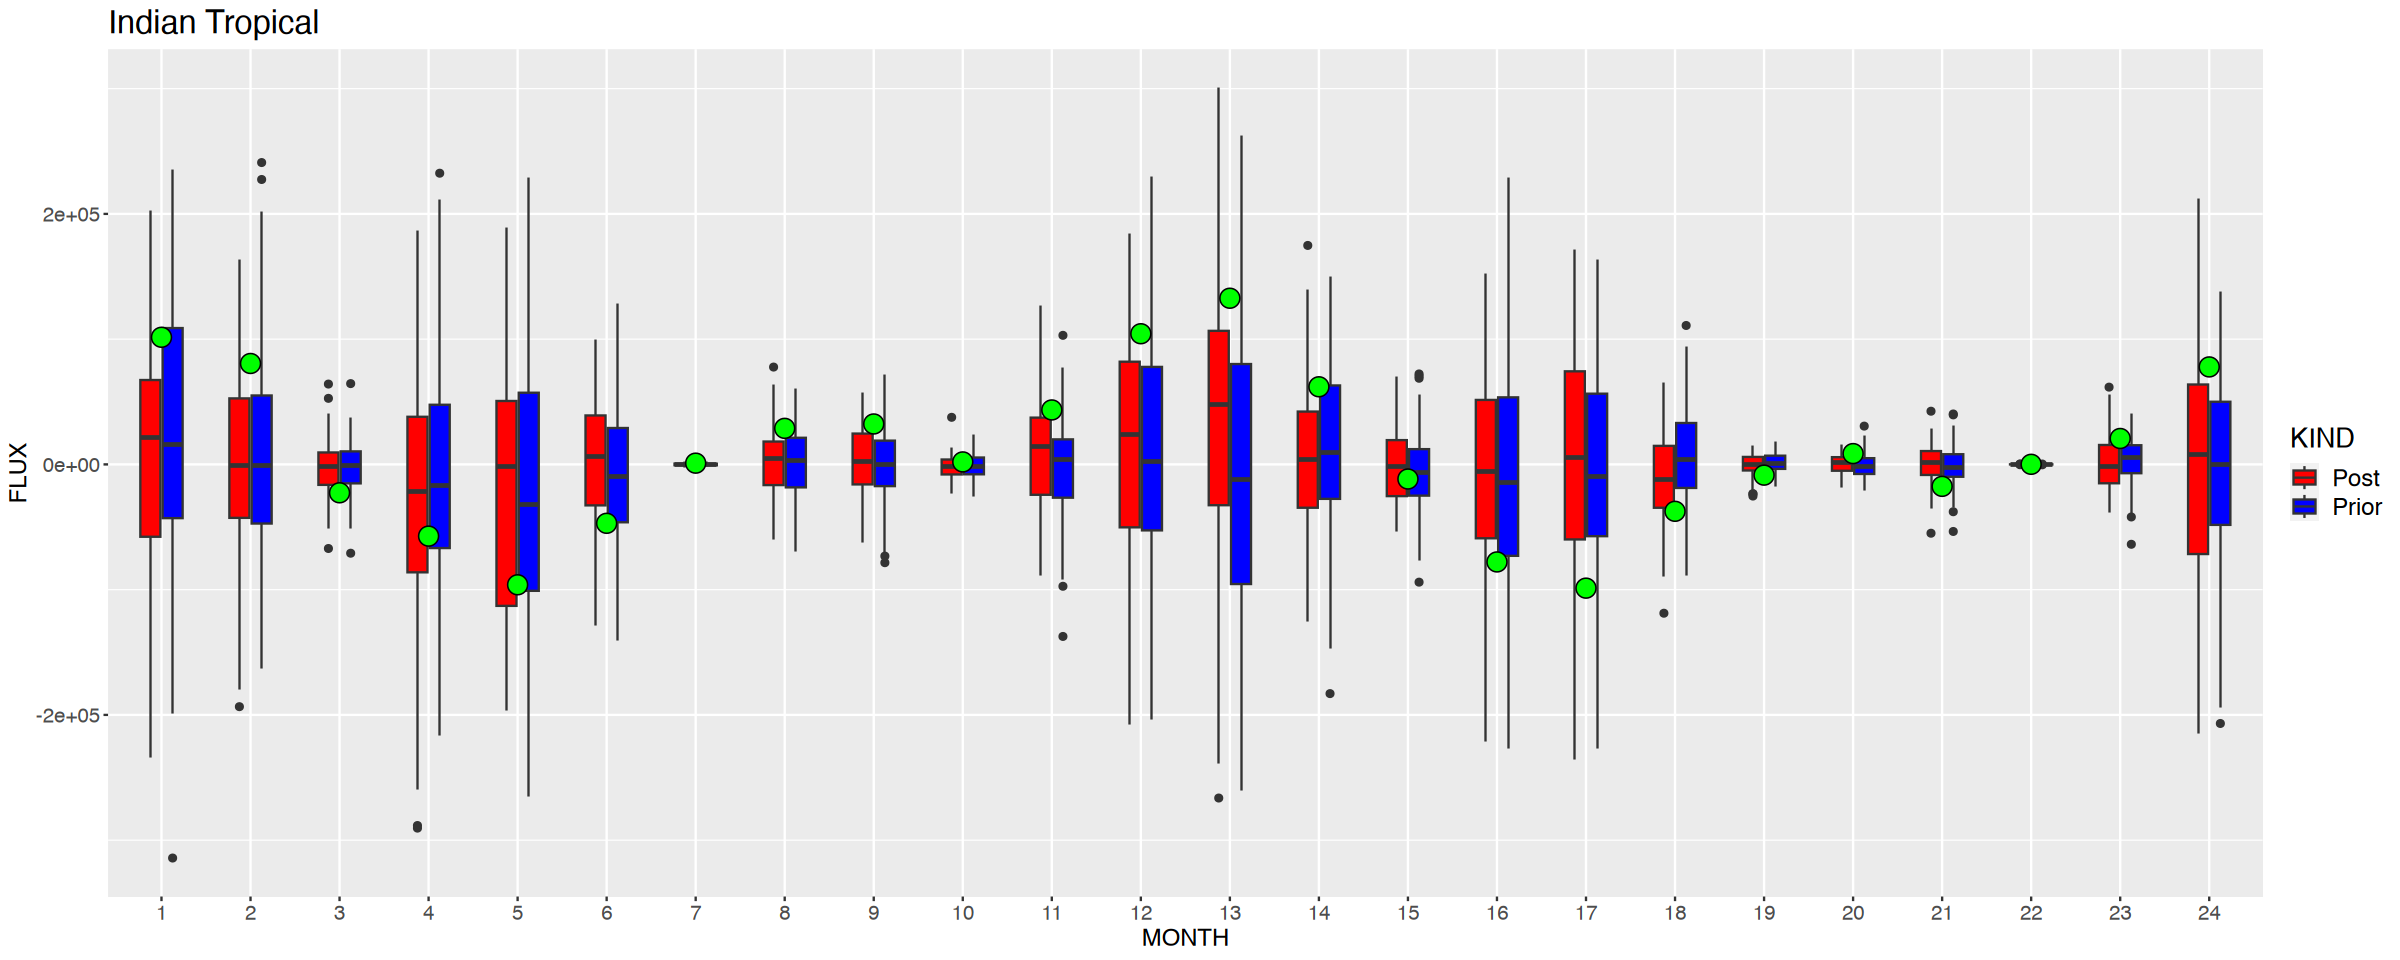

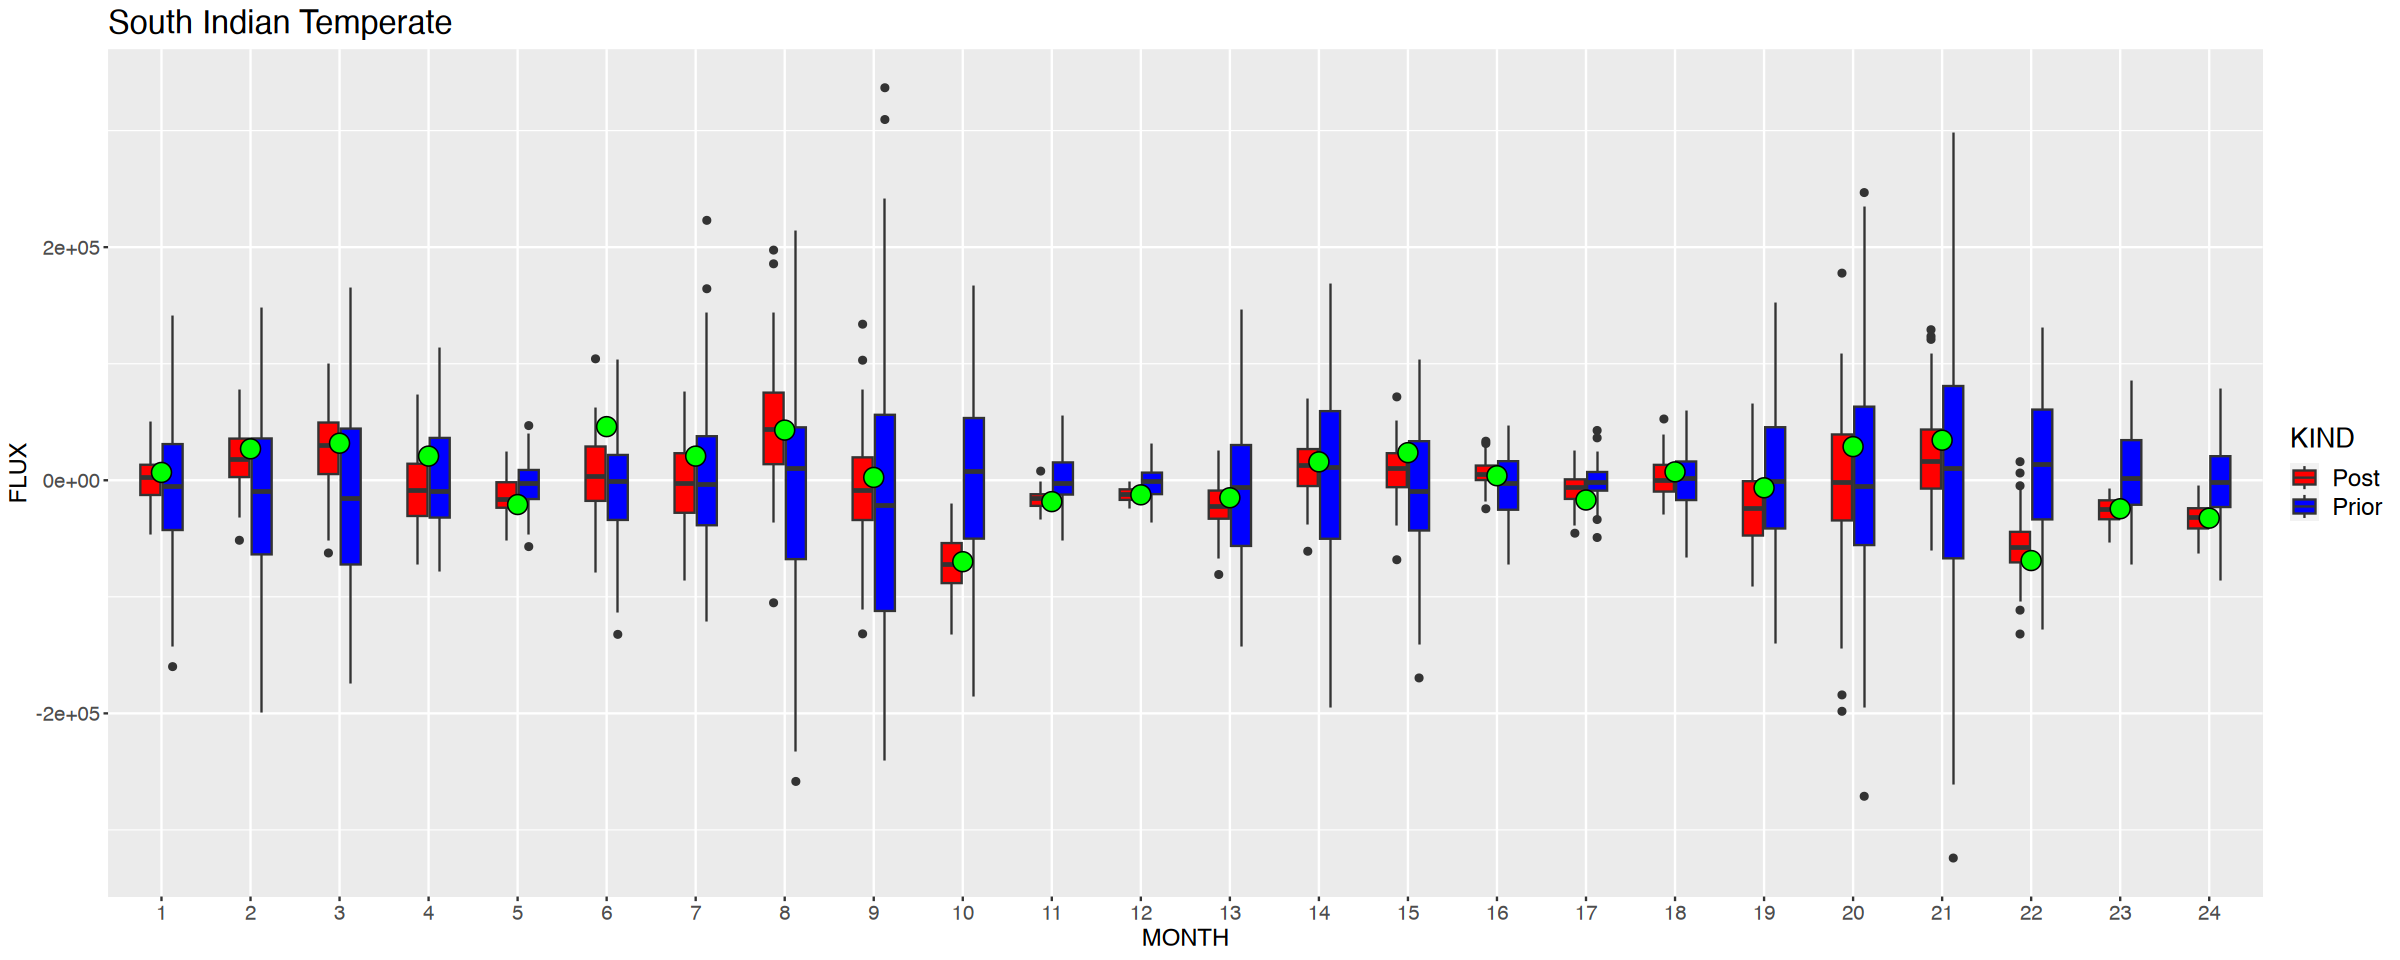

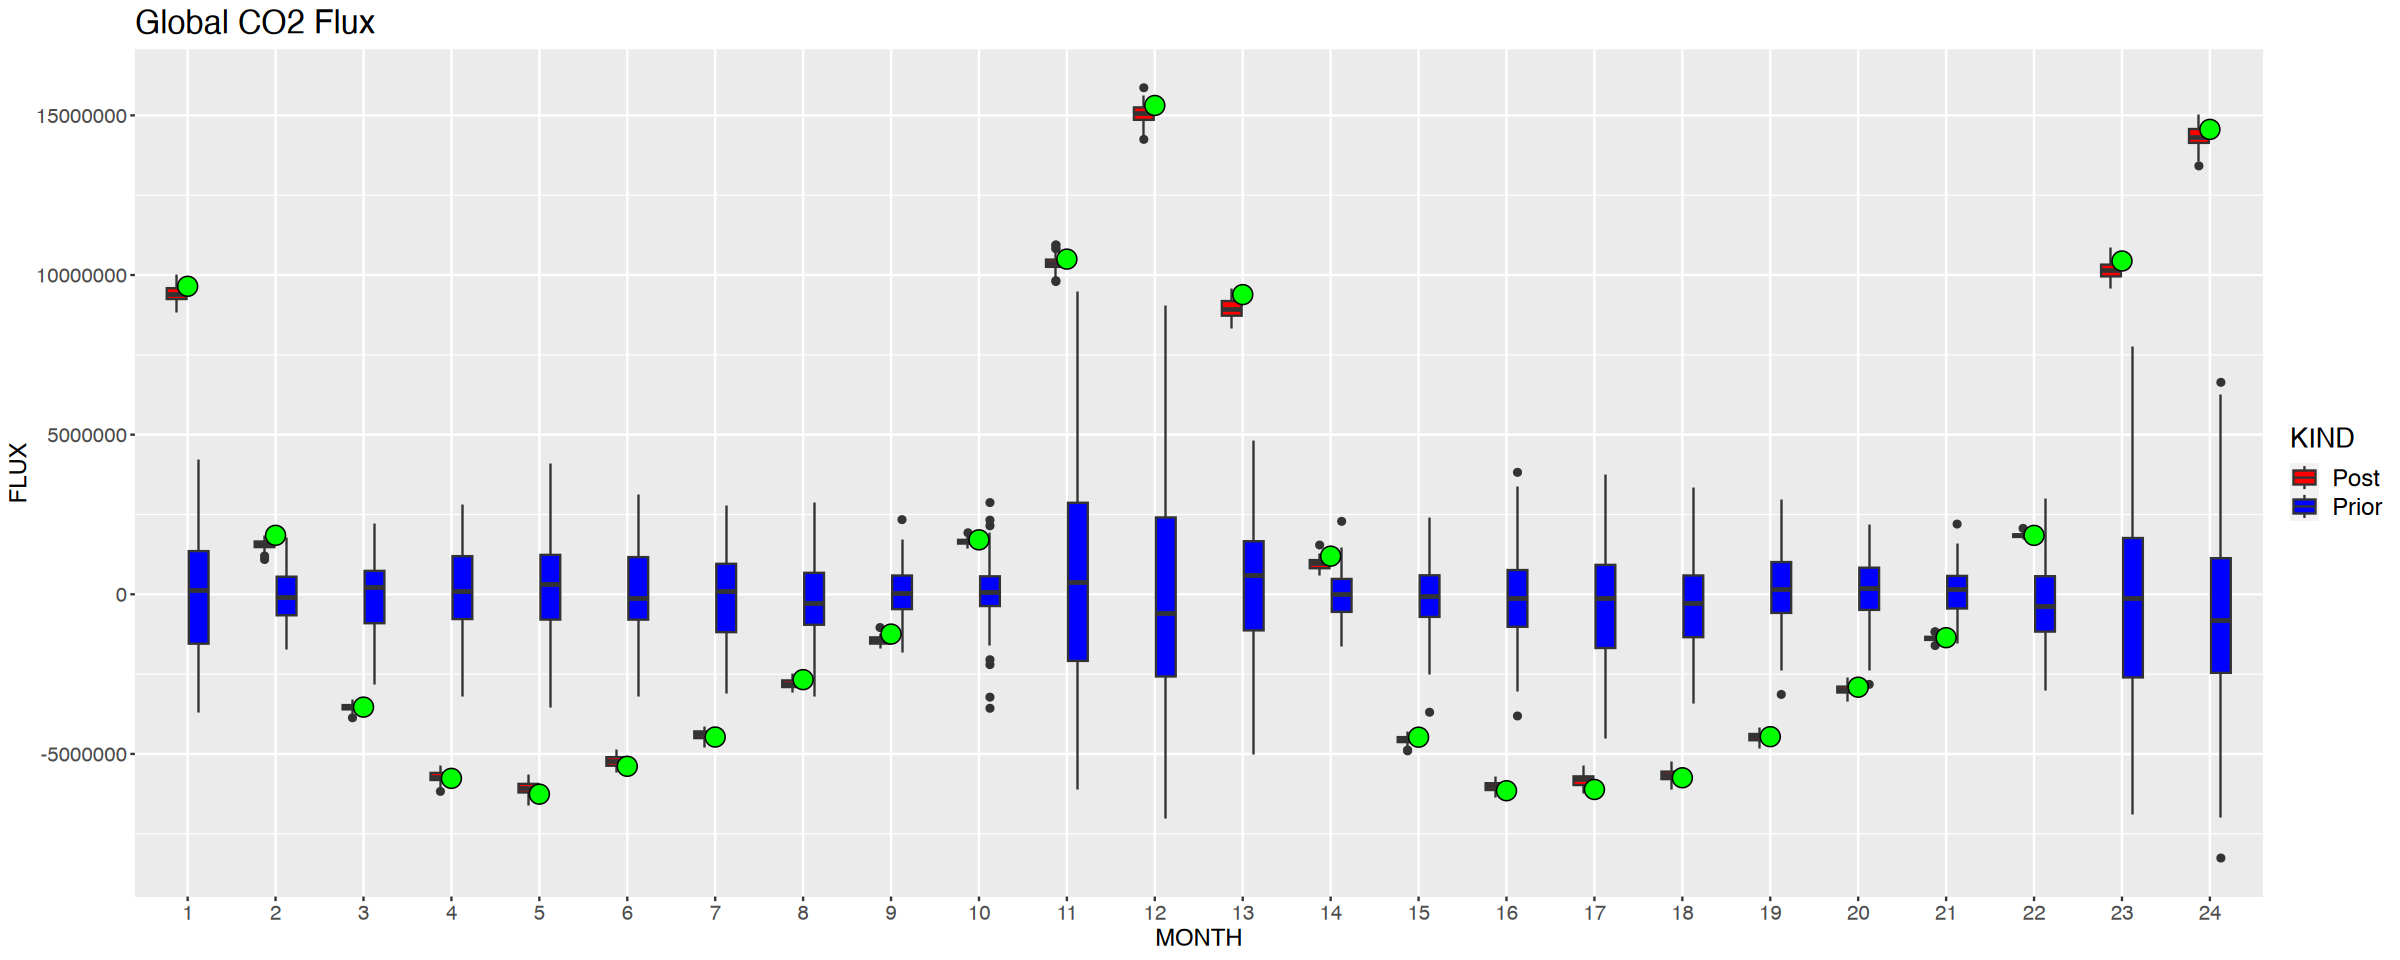

In [97]:
plot_transcom_flux_by_month(data=ret)

Here we are plotting the correlations in the flux estimates for each of the 22 transcom regions.  Instead of calculating correlations analytically from $$\newcommand{\transpose}[1]{{#1^{\scriptscriptstyle T}}} \transpose{(flux)} \Sigma_{\hat{x}} $$ where $$flux$$ is a column vector of monthly fluxes from the 22 transcom regions, we are instead using "realizations" or "samples" from the posterior distribution to approximate it. For this plot of the correlation matrix, we are not plotting the values along the "diagonal" as these are all equal to 1 for all correlation matrices.

[1] "you have 12 cores to work with"


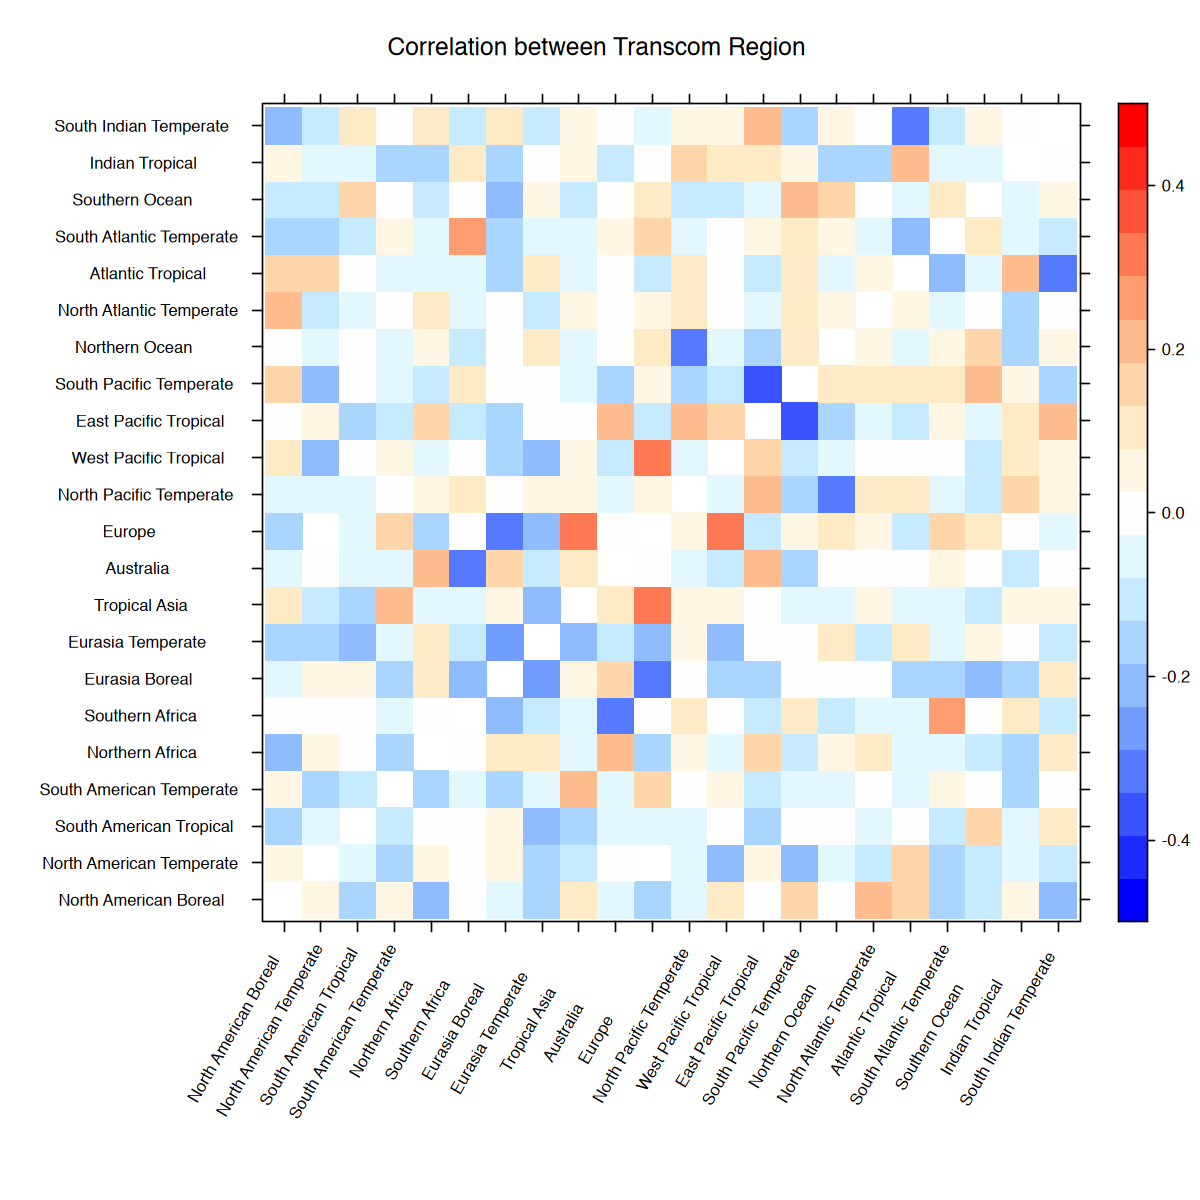

In [17]:
#-- Plot sample 2 yr transcom region flux covariance matrix
#-- need to pull in transcom region names to plot
require(parallel)
print(paste("you have",detectCores(),"cores to work with"))
cl <- makeCluster(detectCores() - 2, type = "FORK")

d = load.ncdf("/Users/aschuh/test_output_posterior/gridded_fluxes.nc4")
dd.tr = parApply(cl,d$flux.samples,c(3,4),FUN=function(x){grid2transcom(x)}) %>% aperm(c(2,3,1)) #project map onto transcom regions
dd.tr = aaply(dd.tr,c(2,3),sum)
aa = cov(dd.tr)
aa = aa[-1,-1] #drop first element (empty transcom, Region==0)
dimnames(aa) = list(transcom_names,transcom_names)
aa = cov2cor(aa) # convert covariance matrix to correlation matrix
options(repr.plot.width = 10, repr.plot.height = 10)
levelplot(cov2cor(aa),col.regions=my.col(20),at=seq(-0.5,0.5,length=20),main="Correlation between Transcom Region ",scales=list(x=list(rot=60)),
         xlab="",ylab="")
#as.data.frame(aa) %>% 
#  ggplot(aes(x = colnames(aa), y = rownames(aa))) +
#  geom_raster()
stopCluster(cl)

In [22]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Ventura 13.4.1

Matrix products: default
BLAS:   /System/Library/Frameworks/Accelerate.framework/Versions/A/Frameworks/vecLib.framework/Versions/A/libBLAS.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Denver
tzcode source: internal

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] dplyr_1.1.4     plyr_1.8.8      mvtnorm_1.2-4   ncdf4_1.21     
[5] lattice_0.21-8  MixMatrix_0.2.6 Matrix_1.5-4.1  ggplot2_3.4.2  

loaded via a namespace (and not attached):
 [1] gtable_0.3.3     jsonlite_1.8.7   compiler_4.3.1   crayon_1.5.2    
 [5] tidyselect_1.2.0 Rcpp_1.0.11      IRdisplay_1.1    scales_1.2.1    
 [9] uuid_1.2-0       fastmap_1.1.1    IR